# Adding different classification models except in the research paper to the experimentation process.
- Logistic Regression
- Neural Network

✅ Code Workflow (English)
1. Model training and evaluation using train_classes.csv
   - Split the training data further into train and validation subsets
   - Perform hyperparameter tuning with GridSearchCV or similar methods
   - Assess performance on the validation set

2. Final evaluation using test_classes.csv
   - Use the optimal model trained on train + validation data
   - Generate predictions on the test set
   - This step serves as the “final (production) evaluation”

3. Re-training and evaluation using the combined train_classes.csv and test_classes.csv
   - Rebuild the model using the entire dataset
   - Obtain the final model trained on all available data


✅ コードの流れ
1. train_classes.csv を使ってモデル作成 & 評価
    - train データをさらに train/validation に分割
    - GridSearchCV などでハイパーパラメータ探索
    - validation データで性能を確認
2. test_classes.csv を使って最終評価
    - train+validation で学習した最適モデルを固定
    - test データで予測
    - ここが「本番評価」に相当
3. train_classes.csv + test_classes.csv を結合して再学習 & 評価
    - データ全体を使ってモデルを再構築
    - 最終的な「全データで学習したモデル」を得る
    - このモデルを保存して、実運用や新しい未知データに備える


📌 １と３のコード　

1.特徴量抽出の準備
- 画像を読み込み、RGBとCMY色空間の各チャンネルから平均値・標準偏差を計算（12次元の特徴量ベクトル）
- ラベルCSVを読み込み、複数ラベルを単一ラベル（miner, phoma, rust, nodisease）に変換

2.データ前処理
- 特徴量とラベルを取得
- 学習用と検証用に分割（train/test split）
- ラベルを数値化（LabelEncoder）
- 特徴量を標準化（StandardScaler）

3.モデル構築とハイパーパラメータ探索
- GridSearchCVで最適なパラメータを探索（交差検証）
- 最適モデルを取得

4.モデル評価
- 学習したモデルで検証データを予測
- 精度（Accuracy）、適合率（Precision）、再現率（Recall）、F1スコアを micro/macro 平均で算出
- 混同行列を可視化（heatmap）
- ROC曲線を描画し、各クラスごとのAUCを確認


## 0.Preprocessing Data

画像を読み込み、RGBとCMY色空間の各チャンネルから平均値・標準偏差を計算（12次元の特徴量ベクトル）

全体の流れ
- 画像を読み込む
- RGBとCMYの統計特徴量を抽出（12次元ベクトル）
- ラベルを単一カテゴリに変換
- 特徴量とラベルを返す → 機械学習モデルに入力可能な形になる

この features_array と labels を 学習データとして使えばOK

In [26]:
import numpy as np
from PIL import Image # 画像の読み込み・リサイズなどを行うライブラリ
import os

# 目的: RGB画像を CMY 色空間に変換
def rgb_to_cmy(rgb_image):
    # CMY = 1 - RGB
    cmy_image = 1.0 - rgb_image                 # RGB値は [0,1] に正規化されているので、1 - RGB で簡単に CMY を得られる
    return cmy_image                            # 出力は同じ形状の配列（画像データ）

# 目的: 画像から統計的な色特徴量を抽出。RGBとCMYそれぞれのチャンネルごとに平均値と標準偏差を計算
def extract_color_features(image):
    features = []
    # RGB features (6)
    for channel in range(3):                    # R, G, B
        channel_data = image[:, :, channel]
        features.append(np.mean(channel_data))  # Mean
        features.append(np.std(channel_data))   # Standard deviation
    
    # CMY features (6)
    cmy_image = rgb_to_cmy(image)
    for channel in range(3):                    # C, M, Y
        channel_data = cmy_image[:, :, channel]
        features.append(np.mean(channel_data))  # Mean
        features.append(np.std(channel_data))   # Standard deviation
    
    return np.array(features)                   # 合計で 12次元の特徴ベクトル（RGB 6 + CMY 6）

# 目的: データセット全体から特徴量とラベルを作成
def load_and_extract_features(image_dir, labels_df):
    features_list = []
    valid_indices = []
    
    for idx, row in labels_df.iterrows():                       # labels_df → CSVから読み込んだラベル情報（idと病気ラベル）
        img_path = os.path.join(image_dir, f"{row['id']}.jpg")  # img_path → idに対応する画像ファイルを探す
        
        if os.path.exists(img_path):                            # 画像が存在すれば
            img = Image.open(img_path)
            img_resized = img.resize((410, 205)) # resize to 410x205    # 読み込み → リサイズ (410×205) → 正規化 (0〜1)。
            img_array = np.array(img_resized).astype('float32') / 255.0 # normalize
            
            features = extract_color_features(img_array)
            features_list.append(features)                      # 特徴量抽出 → リストに追加
            valid_indices.append(idx)
        else:
            print(f"Warning: {img_path} not found")             # 存在しなければ警告を表示
    
    features_array = np.array(features_list)
    labels = labels_df.loc[valid_indices].reset_index(drop=True)
    
    return features_array, labels                               # 全画像の特徴量 (N×12), 有効なラベル情報　　この features_array と labels を 学習データとして使えばOK

# 目的: 複数ラベル形式（miner, phoma, rust, nodisease）を単一ラベルに変換
def convert_to_single_label(row):
    if row['miner'] == 1:
        return 'miner'
    elif row['phoma'] == 1:
        return 'phoma'
    elif row['rust'] == 1:
        return 'rust'
    else:
        return 'nodisease'

## 1. Use the Train dataset to build models and perform evaluation

複数ラベルを単一ラベルに変換
ラベルCSVを読み込み、複数ラベルを単一ラベル（miner, phoma, rust, nodisease）に変換。

全体の流れ
- CSVからラベルを読み込み → 単一ラベルに変換
- 画像から特徴量を抽出
- 学習用と検証用に分割（クラス比率を維持）
- ラベルを数値化（モデルに渡せる形）
- 特徴量を標準化（学習を安定させる）

これで 「モデルに渡せる形のデータセット」 が完成
- X_train_scaled → 学習用特徴量
- y_train_encoded → 学習用ラベル
- X_valid_scaled → 検証用特徴量
- y_valid_encoded → 検証用ラベル

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder 
import pandas as pd

# トレーニングデータを読み込み
train_label_df = pd.read_csv('dataset/train_classes.csv')

# convert_to_single_label 関数を使って、複数ラベル形式（miner, phoma, rust, nodisease）を 単一ラベル文字列 に変換 - 例: miner=1, phoma=0, rust=0 → 'miner'
train_label_df['label'] = train_label_df.apply(convert_to_single_label, axis=1)
print(train_label_df.head())     # ★

# 画像ディレクトリとラベル情報を渡して、各画像から抽出した train_features → 12次元の特徴量ベクトル、train_labels → 有効なラベル情報を取得
train_features, train_labels = load_and_extract_features('dataset/coffee-leaf-diseases/train/images', train_label_df)

# ラベル分布を確認
print(train_labels['label'].value_counts())   # ←ここに入れると良い

# トレーニングデータを学習用と検証用に分割
X_train, X_valid, y_train, y_valid = train_test_split(
    train_features,
    train_labels['label'],
    test_size=0.2,
    stratify=train_labels['label'],     # クラスの割合を保ったまま分割（偏り防止）
    random_state=123
)

# ラベルの数値化
label_encoder = LabelEncoder()                              # 文字列ラベルを数値に変換。例: ['miner', 'phoma', 'rust', 'nodisease'] → [2, 1, 3, 0] のような整数
y_train_encoded = label_encoder.fit_transform(y_train)      # 学習用データで fit → 検証用データは同じ変換を適用。
y_valid_encoded = label_encoder.transform(y_valid)

# 特徴量の標準化
scaler = StandardScaler()                                   # StandardScaler で特徴量を標準化。平均0、標準偏差1に変換
X_train_scaled = scaler.fit_transform(X_train)              # 学習用データで fit → 検証用データは同じスケーリングを適用
X_valid_scaled = scaler.transform(X_valid)

   id  miner  rust  phoma      label
0   0      0     0      0  nodisease
1   1      0     0      0  nodisease
2   2      0     0      0  nodisease
3   3      0     0      0  nodisease
4   4      0     0      0  nodisease
label
phoma        388
miner        332
nodisease    284
rust         260
Name: count, dtype: int64


### Hyperparameter Tuning and GridSearch

モデル構築とハイパーパラメータ探索

全体の流れ
- それぞれのモデルのハイパーパラメータ範囲を指定
- GridSearchCV で交差検証しながら最適なパラメータを探索
- 最適なモデル (best_model_dt, best_model_knn) を取得
- 最適パラメータとスコアを表示

✅ ハイパーパラメータとは？
- 学習の前に固定する値（例: 決定木の深さ、KNN の近傍数、正則化の強さなど）
- モデルが「どう学習するか」を決めるルールで、学習データから自動的に最適化されるものではない。

✅ Grid Search の役割
- 候補のハイパーパラメータをあらかじめ決めておく
→ その範囲の中で「総当たり」で試す。
- 各組み合わせについて交差検証 (cross-validation) を行い、平均スコアが最も良い組み合わせを選ぶ。

✅ なぜ「決めてから」Grid Searchするのか？
- 探索範囲を制御するため
- ハイパーパラメータは無限に候補があるわけではない。
- 例えば max_depth を 1〜20 に制限することで、計算量を現実的に抑える。
- モデルの特性に合わせるため
- KNNなら「近傍数」「距離の種類」が重要。
- Logistic Regressionなら「正則化強度 C」「solver」が重要。
- それぞれのモデルに意味のある範囲を指定する必要がある。
- 過学習や未学習を防ぐため
- 極端な値（例: 決定木の深さを無制限）を含めると過学習になる。
- 候補を適切に絞ることで、汎化性能の高いモデルを選びやすくなる。
- 再現性と効率性
- 候補を明示的に決めることで、同じ条件で再実験できる。
- ランダム探索よりも「全て試した」という安心感がある。


In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# ---------- Decision Tree ----------
#　max_features=None → 全特徴量を使う。splitter='best' → 最適な分割を選択
dt = DecisionTreeClassifier(max_features=None, random_state=123, splitter='best')

# 探索するハイパーパラメータの範囲を指定 「この範囲の中で試してね」と候補を渡す
param_grid_dt = {
    'criterion': ['gini', 'entropy'],               # 不純度の指標（ジニ係数 or エントロピー）
    'max_depth': list(range(1, 21)) + [None],       # 木の深さ（1〜20、または制限なし）
    'min_samples_split': range(2, 11),              # ノードを分割するための最小サンプル数（2〜10）
    'min_samples_leaf': range(1, 6)                 # 葉ノードに必要な最小サンプル数（1〜5）
}

# GridSearchCVで総当たり探索
grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=10) # 10分割交差検証（cv=10）でグリッドサーチを実行
grid_search_dt.fit(X_train_scaled, y_train)             # 学習データ X_train_scaled とラベル y_train を使って最適なパラメータを探索

# 最適なハイパーパラメータを取得
best_model_dt = grid_search_dt.best_estimator_      # 最適なパラメータで学習された決定木モデル
print(grid_search_dt.best_params_)                  # 最適なパラメータの組み合わせ
print(grid_search_dt.best_score_)                   # 交差検証での平均スコア


# ---------- KNN ----------
# algorithm='auto' → 最適なアルゴリズムを自動選択。leaf_size=30 → KDTree/BallTreeの葉サイズ。 p=2 → 距離計算にユークリッド距離（L2ノルム）。 weights='uniform' → 全近傍に同じ重み
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, n_jobs=-1, p=2, weights='uniform')

# 探索するハイパーパラメータの範囲を指定 「この範囲の中で試してね」と候補を渡す
param_grid_knn = {
    'metric': ['euclidean', 'manhattan'],           # 距離の種類（ユークリッド or マンハッタン）
    'n_neighbors': range(1, 21),                    # 近傍数（1〜20）
}

# GridSearchCVで総当たり探索
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=10)  # 10分割交差検証でグリッドサーチを実行
grid_search_knn.fit(X_train_scaled, y_train)

# 最適なハイパーパラメータを取得
best_model_knn = grid_search_knn.best_estimator_    # 最適なパラメータで学習されたKNNモデル
print(grid_search_knn.best_params_)                 # 最適なパラメータの組み合わせ
print(grid_search_knn.best_score_)                  # 交差検証での平均スコア


# ---------- Logistic Regression ----------(Not in the paper, it is an additional test)
lr = LogisticRegression(max_iter=1000, random_state=123)

# 探索するハイパーパラメータの範囲を指定 「この範囲の中で試してね」と候補を渡す
param_grid_lr = {
    'solver': ['lbfgs', 'saga'],                    # 多クラス分類に強い solver
    'C': [0.01, 0.1, 1, 10],                        # 正則化の強さ (小さいほど強い)
    'penalty': ['l2']                               # L2 正則化のみ（sagaならl1も可）
}

# GridSearchCVで総当たり探索
grid_search_lr = GridSearchCV(lr, param_grid_lr, cv=10, scoring='accuracy', n_jobs=-1)
grid_search_lr.fit(X_train_scaled, y_train)

# 最適なパラメータとスコアを表示
best_model_lr = grid_search_lr.best_estimator_
print(grid_search_lr.best_params_)
print(grid_search_lr.best_score_)


# ---------- Neural network ----------(Not in the paper, it is an additional test)
# MLP（多層パーセプトロン）
nn = MLPClassifier(max_iter=5000, random_state=123)

# 探索するハイパーパラメータの範囲を指定 「この範囲の中で試してね」と候補を渡す
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],   # 隠れ層が1層でユニット数が50、-隠れ層が1層でユニット数が100、隠れ層が2層で1層目に100ユニット、2層目に50ユニット
    # adam: Adaptive Moment Estimation 勾配降下法の一種。学習率を自動調整しながら更新。大規模データや特徴量が多い場合強い。小規模データは収束不安定な事がある。
    # lbfgs: Limited-memory BFGS 準ニュートン法の一種。二階微分（ヘッセ行列）を近似して最適化。小〜中規模データセットで非常に効率的。収束が安定しやすい。
    'solver': ['adam', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01],  # 正則化パラメータ   # 小さい値 (0.0001) 正則化が弱い → モデルが複雑になりやすい → 過学習のリスクあり。大きい値（0.01） モデルがシンプルになる → 汎化性能が上がる可能性あり、ただし学習が難しくなることも。
    'learning_rate_init': [0.001, 0.01]
}

# GridSearchCVで総当たり探索
grid_search_nn = GridSearchCV(estimator=nn, param_grid=param_grid,cv=10, scoring='accuracy', n_jobs=-1) # 10分割交差検証（cv=10）でグリッドサーチを実行
grid_search_nn.fit(X_train_scaled, y_train)     # 学習データ X_train_scaled とラベルy_trainを使って最適なパラメータを探索

# 最適なパラメータとスコアを表示
best_model_nn = grid_search_nn.best_estimator_      # 最適なパラメータで学習されたNeural Networkモデル
print(grid_search_nn.best_params_)                  # 最適なパラメータの組み合わせ
print(grid_search_nn.best_score_)                   # 交差検証での平均スコア

{'criterion': 'entropy', 'max_depth': 13, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.994059405940594
{'metric': 'euclidean', 'n_neighbors': 1}
0.993069306930693
{'C': 10, 'penalty': 'l2', 'solver': 'saga'}
0.7220442632498544
{'alpha': 0.001, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001, 'solver': 'lbfgs'}
0.9970297029702969


In [29]:
pd.set_option('display.max_colwidth', None)  # 列の表示幅を制限しない
pd.set_option('display.max_columns', None)   # 全列を表示
pd.set_option('display.width', None)         # 横幅制限なし

results = []
for name, gs in [("Decision Tree", grid_search_dt),
                 ("KNN", grid_search_knn),
                 ("Logistic Regression", grid_search_lr),
                 ("Neural Network", grid_search_nn)]:
    results.append({
        "Model": name,
        "Best Params": gs.best_params_,
        "CV Score": gs.best_score_
    })
pd.DataFrame(results)

,Model,Best Params,CV Score
0,Decision Tree,"{'criterion': 'entropy', 'max_depth': 13, 'min_samples_leaf': 1, 'min_samples_split': 2}",0.994059
1,KNN,"{'metric': 'euclidean', 'n_neighbors': 1}",0.993069
2,Logistic Regression,"{'C': 10, 'penalty': 'l2', 'solver': 'saga'}",0.722044
3,Neural Network,"{'alpha': 0.001, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001, 'solver': 'lbfgs'}",0.997030


### Evaluation using the best parameters

モデル訓練と予測

- トレーニングデータの中のトレーニングデータで訓練
- トレーニングデータの中の検証データで予測
- 精度・適合率・再現率・F1スコアを出力（micro/macro両方）

GridSearchCVで得たbest_model_xxx を使って検証データを予測

まとめ
- このコードは GridSearchCVで選ばれた最適なモデルを使って評価している
- 以前のコードでは「手動指定パラメータ」で評価していたが、今回は「最適パラメータ」での性能比較
- 出力される指標は Accuracy, Precision, Recall, F1-score を micro/macro 平均で算出
- これで「最適化したモデルがどれくらい改善したか」を確認できる


In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ---------- Decision Tree ----------
y_pred_valid_dt_best = best_model_dt.predict(X_valid_scaled)

print("\n=== Decision Tree Overall Metrics ===")
print("Accuracy (subset accuracy):", accuracy_score(y_valid, y_pred_valid_dt_best))
print("Precision (micro):", precision_score(y_valid, y_pred_valid_dt_best, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_valid, y_pred_valid_dt_best, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_valid, y_pred_valid_dt_best, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_valid, y_pred_valid_dt_best, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_valid, y_pred_valid_dt_best, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_valid, y_pred_valid_dt_best, average='macro', zero_division=0))

# ---------- KNN ----------
y_pred_valid_knn_best = best_model_knn.predict(X_valid_scaled)

print("\n=== KNN Overall Metrics ===")
print("Accuracy (subset accuracy):", accuracy_score(y_valid, y_pred_valid_knn_best))
print("Precision (micro):", precision_score(y_valid, y_pred_valid_knn_best, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_valid, y_pred_valid_knn_best, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_valid, y_pred_valid_knn_best, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_valid, y_pred_valid_knn_best, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_valid, y_pred_valid_knn_best, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_valid, y_pred_valid_knn_best, average='macro', zero_division=0))

# ---------- Logistic Regression ---------- (Not in the paper, it is an additional test)
y_pred_valid_lr_best = best_model_lr.predict(X_valid_scaled)

print("\n=== Logistic Regression Overall Metrics ===")
print("Accuracy (subset accuracy):", accuracy_score(y_valid, y_pred_valid_lr_best))
print("Precision (micro):", precision_score(y_valid, y_pred_valid_lr_best, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_valid, y_pred_valid_lr_best, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_valid, y_pred_valid_lr_best, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_valid, y_pred_valid_lr_best, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_valid, y_pred_valid_lr_best, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_valid, y_pred_valid_lr_best, average='macro', zero_division=0))

# ---------- Neural Network ---------- (Not in the paper, it is an additional test)
y_pred_valid_nn_best = best_model_nn.predict(X_valid_scaled)

print("\n=== Neural Network Overall Metrics ===")
print("Accuracy (subset accuracy):", accuracy_score(y_valid, y_pred_valid_nn_best))
print("Precision (micro):", precision_score(y_valid, y_pred_valid_nn_best, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_valid, y_pred_valid_nn_best, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_valid, y_pred_valid_nn_best, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_valid, y_pred_valid_nn_best, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_valid, y_pred_valid_nn_best, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_valid, y_pred_valid_nn_best, average='macro', zero_division=0))


=== Decision Tree Overall Metrics ===
Accuracy (subset accuracy): 1.0
Precision (micro): 1.0
Recall (micro): 1.0
F1-score (micro): 1.0
Precision (macro): 1.0
Recall (macro): 1.0
F1-score (macro): 1.0

=== KNN Overall Metrics ===
Accuracy (subset accuracy): 1.0
Precision (micro): 1.0
Recall (micro): 1.0
F1-score (micro): 1.0
Precision (macro): 1.0
Recall (macro): 1.0
F1-score (macro): 1.0

=== Logistic Regression Overall Metrics ===
Accuracy (subset accuracy): 0.7114624505928854
Precision (micro): 0.7114624505928854
Recall (micro): 0.7114624505928854
F1-score (micro): 0.7114624505928854
Precision (macro): 0.6890723503244232
Recall (macro): 0.6926297386823703
F1-score (macro): 0.6890021862403498

=== Neural Network Overall Metrics ===
Accuracy (subset accuracy): 1.0
Precision (micro): 1.0
Recall (micro): 1.0
F1-score (micro): 1.0
Precision (macro): 1.0
Recall (macro): 1.0
F1-score (macro): 1.0


In [31]:
results_valid = []
for name, model, y_pred in [
    ("Decision Tree", best_model_dt, y_pred_valid_dt_best),
    ("KNN", best_model_knn, y_pred_valid_knn_best),
    ("Logistic Regression", best_model_lr, y_pred_valid_lr_best),
    ("Neural Network", best_model_nn, y_pred_valid_nn_best)
]:
    results_valid.append({
        "Model": name,
        "Accuracy": accuracy_score(y_valid, y_pred),
        "Precision (micro)": precision_score(y_valid, y_pred, average='micro', zero_division=0),
        "Recall (micro)": recall_score(y_valid, y_pred, average='micro', zero_division=0),
        "F1-score (micro)": f1_score(y_valid, y_pred, average='micro', zero_division=0),
        "Precision (macro)": precision_score(y_valid, y_pred, average='macro', zero_division=0),
        "Recall (macro)": recall_score(y_valid, y_pred, average='macro', zero_division=0),
        "F1_macro (macro)": f1_score(y_valid, y_pred, average='macro', zero_division=0),
    })
pd.DataFrame(results_valid)

,Model,Accuracy,Precision (micro),Recall (micro),F1-score (micro),Precision (macro),Recall (macro),F1_macro (macro)
0,Decision Tree,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000
1,KNN,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000
2,Logistic Regression,0.711462,0.711462,0.711462,0.711462,0.689072,0.69263,0.689002
3,Neural Network,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


### Confusion Matrix Heatmap

#### One by One

混同行列（Decision Tree: 緑、KNN: 青）

→ 正解数は対角線上、誤分類は対角線外。


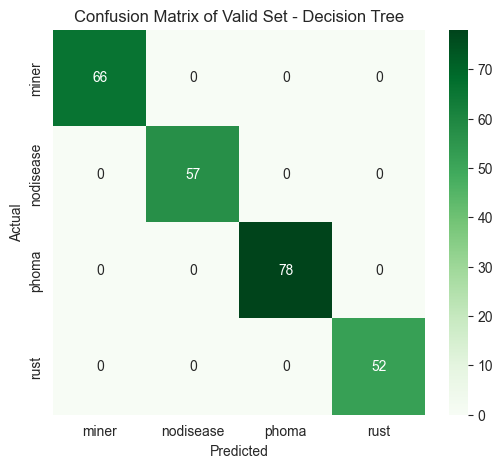

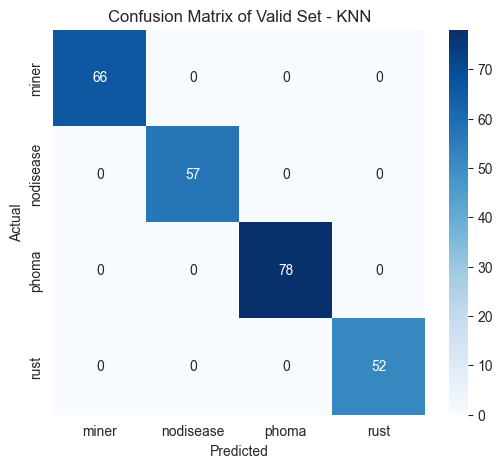

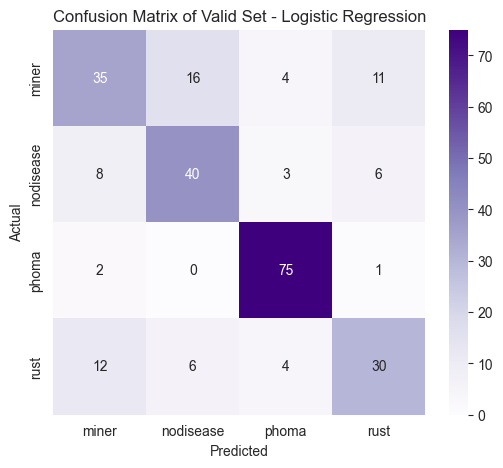

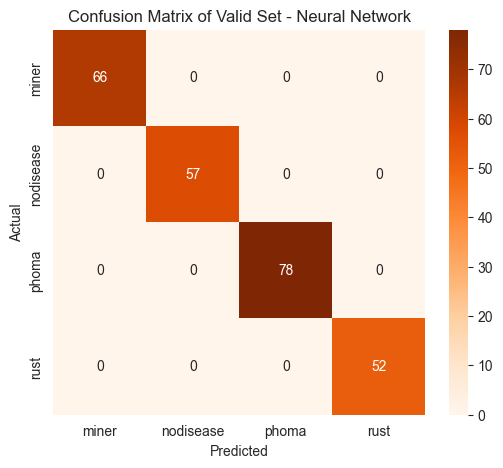

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

labels = sorted(y_valid.unique())                           # 検証データに含まれるラベルを取得し、ソートして並べる

# Decision Tree
cm_valid_dt_best = confusion_matrix(y_valid, y_pred_valid_dt_best)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_valid_dt_best,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Valid Set - Decision Tree')
plt.show()

# KNN
cm_valid_knn_best = confusion_matrix(y_valid, y_pred_valid_knn_best)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_valid_knn_best,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Valid Set - KNN')
plt.show()

# Logistic Regression (Not in the paper, it is an additional test)
cm_valid_lr_best = confusion_matrix(y_valid, y_pred_valid_lr_best)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_valid_lr_best,
    annot=True,
    fmt='d',
    cmap='Purples',
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Valid Set - Logistic Regression')
plt.show()

# Neural Network (Not in the paper, it is an additional test)
cm_valid_nn_best = confusion_matrix(y_valid, y_pred_valid_nn_best)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_valid_nn_best,
    annot=True,
    fmt='d',
    cmap='Oranges',
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Valid Set - Neural Network')
plt.show()

#### Subplot

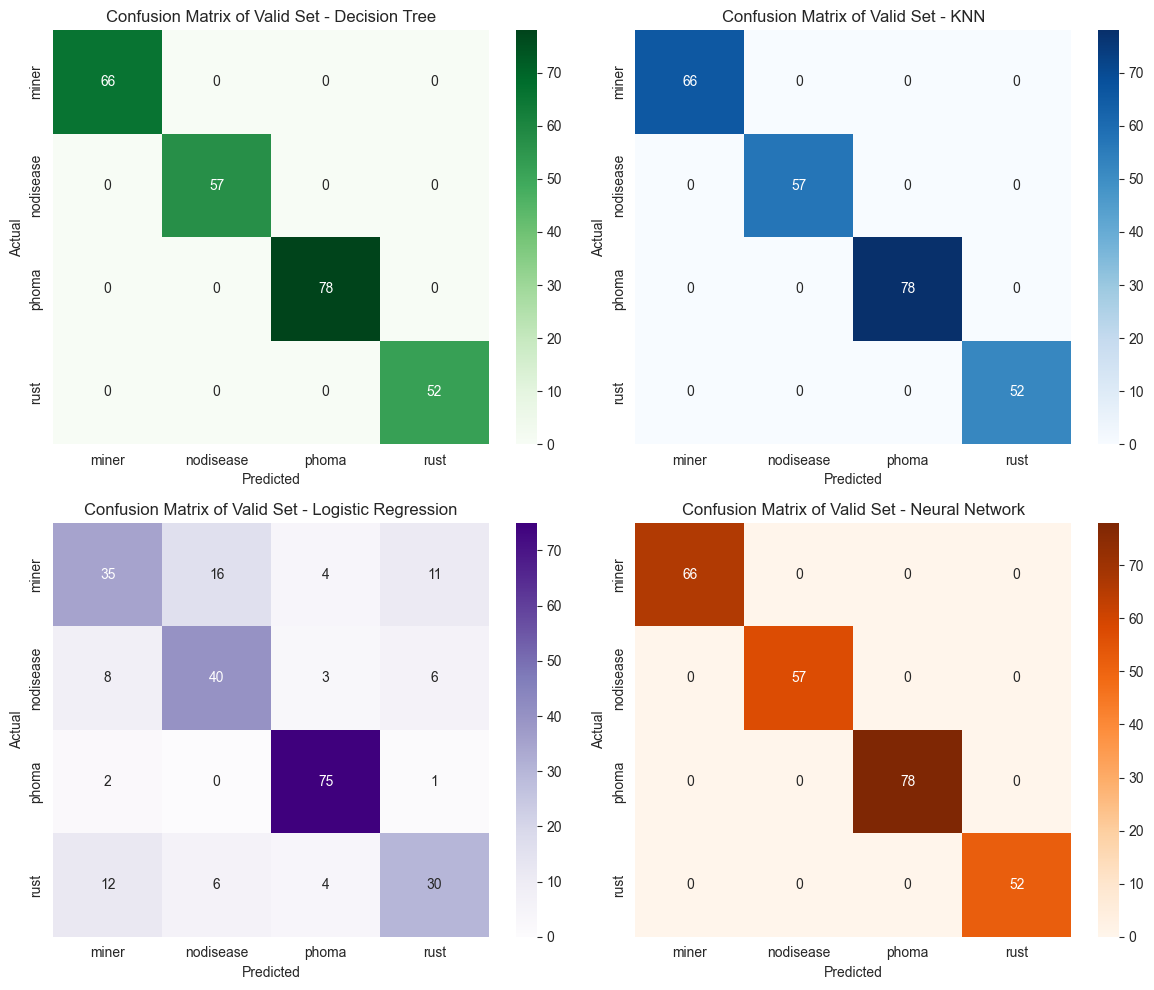

In [33]:
labels = sorted(y_valid.unique())  # 検証データに含まれるラベルを取得

# 各モデルの混同行列を計算
cm_valid_dt_best = confusion_matrix(y_valid, y_pred_valid_dt_best, labels=labels)
cm_valid_knn_best = confusion_matrix(y_valid, y_pred_valid_knn_best, labels=labels)
cm_valid_lr_best = confusion_matrix(y_valid, y_pred_valid_lr_best, labels=labels)
cm_valid_nn_best = confusion_matrix(y_valid, y_pred_valid_nn_best, labels=labels)

# サブプロット作成 (2行×2列)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 各モデルを順番に描画
for ax, cm, title, cmap in zip(
    axes.flatten(),
    [cm_valid_dt_best, cm_valid_knn_best, cm_valid_lr_best, cm_valid_nn_best],
    ["Decision Tree", "KNN", "Logistic Regression", "Neural Network"],
    ["Greens", "Blues", "Purples", "Oranges"]
):
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title(f"Confusion Matrix of Valid Set - {title}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()

### ROC-AUC Curves

#### One by One

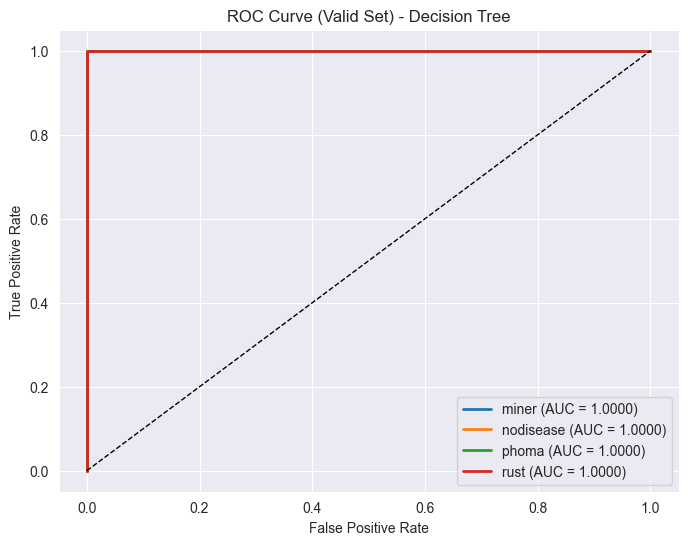

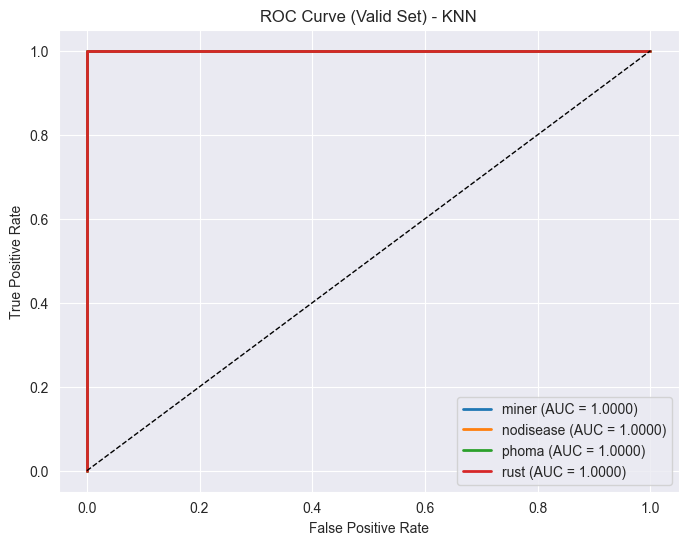

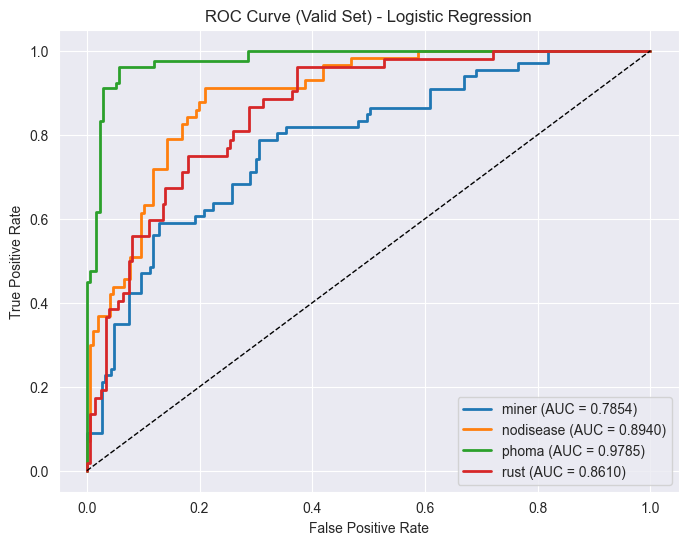

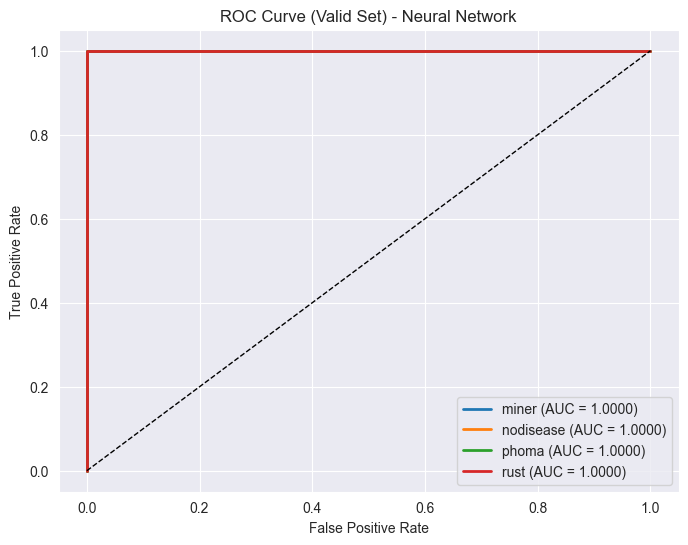

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Decision Tree
y_score_valid_dt_best = best_model_dt.predict_proba(X_valid_scaled)
y_bin_valid_dt_best = label_binarize(y_valid, classes=best_model_dt.classes_)
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(best_model_dt.classes_):
    fpr_dt, tpr_dt, _ = roc_curve(y_bin_valid_dt_best[:, i], y_score_valid_dt_best[:, i])
    roc_auc_dt_best = auc(fpr_dt, tpr_dt)
    plt.plot(
        fpr_dt,
        tpr_dt,
        lw=2,
        label=f'{class_name} (AUC = {roc_auc_dt_best:.4f})'
    )
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Valid Set) - Decision Tree')
plt.legend()
plt.show()

# KNN
y_score_valid_knn_best = best_model_knn.predict_proba(X_valid_scaled)
y_bin_valid_knn_best = label_binarize(y_valid, classes=best_model_knn.classes_)
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(best_model_knn.classes_):
    fpr_knn, tpr_knn, _ = roc_curve(y_bin_valid_knn_best[:, i], y_score_valid_knn_best[:, i])
    roc_auc_knn_best = auc(fpr_knn, tpr_knn)
    plt.plot(
        fpr_knn,
        tpr_knn,
        lw=2,
        label=f'{class_name} (AUC = {roc_auc_knn_best:.4f})'
    )
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Valid Set) - KNN')
plt.legend()
plt.show()

# Logistic Regression (Not in the paper, it is an additional test)
y_score_valid_lr_best = best_model_lr.predict_proba(X_valid_scaled)
y_bin_valid_lr_best = label_binarize(y_valid, classes=best_model_lr.classes_)
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(best_model_lr.classes_):
    fpr_lr, tpr_lr, _ = roc_curve(y_bin_valid_lr_best[:, i], y_score_valid_lr_best[:, i])
    roc_auc_lr_best = auc(fpr_lr, tpr_lr)
    plt.plot(
        fpr_lr,
        tpr_lr,
        lw=2,
        label=f'{class_name} (AUC = {roc_auc_lr_best:.4f})'
    )

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Valid Set) - Logistic Regression')
plt.legend()
plt.show()

# Neural Network (Not in the paper, it is an additional test)
y_score_valid_nn_best = best_model_nn.predict_proba(X_valid_scaled)
y_bin_valid_nn_best = label_binarize(y_valid, classes=best_model_nn.classes_)
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(best_model_nn.classes_):
    fpr_nn, tpr_nn, _ = roc_curve(y_bin_valid_nn_best[:, i], y_score_valid_nn_best[:, i])
    roc_auc_nn_best = auc(fpr_nn, tpr_nn)
    plt.plot(
        fpr_nn,
        tpr_nn,
        lw=2,
        label=f'{class_name} (AUC = {roc_auc_nn_best:.4f})'
    )
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Valid Set) - Neural Network')
plt.legend()
plt.show()

#### Subplot


=== Decision Tree per-class AUC ===
miner: 1.0000
nodisease: 1.0000
phoma: 1.0000
rust: 1.0000
Decision Tree - Macro-average AUC: 1.0000, Micro-average AUC: 1.0000

=== KNN per-class AUC ===
miner: 1.0000
nodisease: 1.0000
phoma: 1.0000
rust: 1.0000
KNN - Macro-average AUC: 1.0000, Micro-average AUC: 1.0000

=== Logistic Regression per-class AUC ===
miner: 0.7854
nodisease: 0.8940
phoma: 0.9785
rust: 0.8610
Logistic Regression - Macro-average AUC: 0.8797, Micro-average AUC: 0.8976

=== Neural Network per-class AUC ===
miner: 1.0000
nodisease: 1.0000
phoma: 1.0000
rust: 1.0000
Neural Network - Macro-average AUC: 1.0000, Micro-average AUC: 1.0000


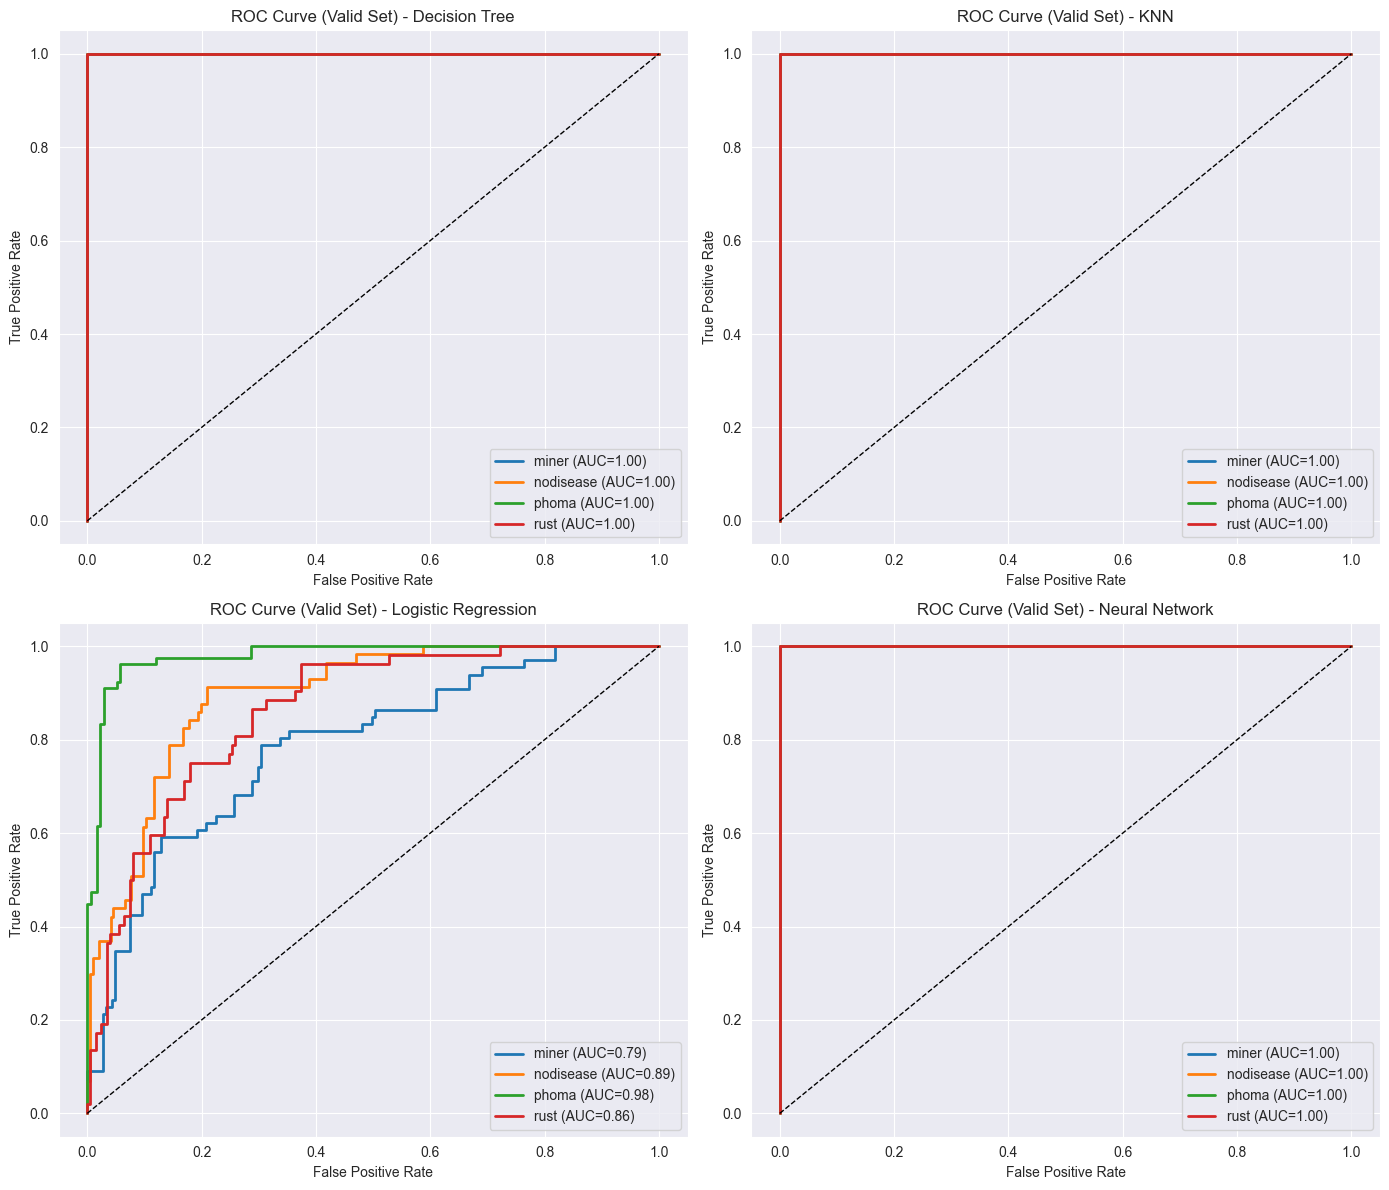

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

# 各モデルのスコアとバイナライズ済みラベル
models_info = [
    ("Decision Tree", best_model_dt, y_pred_valid_dt_best),
    ("KNN", best_model_knn, y_pred_valid_knn_best),
    ("Logistic Regression", best_model_lr, y_pred_valid_lr_best),
    ("Neural Network", best_model_nn, y_pred_valid_nn_best)
]

# サブプロット作成
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for ax, (name, model, y_pred) in zip(axes.flatten(), models_info):
    # 確率スコア
    y_score = model.predict_proba(X_valid_scaled)
    # バイナライズラベル
    y_bin = label_binarize(y_valid, classes=model.classes_)

    print(f"\n=== {name} per-class AUC ===")
    # 各クラスごとの ROC 曲線
    for i, class_name in enumerate(model.classes_):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC={roc_auc:.2f})')
        # ★ printでも出力
        print(f"{class_name}: {roc_auc:.4f}")

    # 基準線
    ax.plot([0, 1], [0, 1], 'k--', lw=1)
    ax.set_title(f"ROC Curve (Valid Set) - {name}")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend()

    # Macro/Micro 平均 AUC を print
    macro_auc = roc_auc_score(y_bin, y_score, average="macro")
    micro_auc = roc_auc_score(y_bin, y_score, average="micro")
    print(f"{name} - Macro-average AUC: {macro_auc:.4f}, Micro-average AUC: {micro_auc:.4f}")

plt.tight_layout()
plt.show()

## Option

おまけ
- 今回はLogistic Regression（線形） と Neural Network（非線形）を比較のために選択
- Neural Network (MLPClassifier) → 教師あり学習 → ラベルを使って学習するので分類精度が高い。
- Hierarchical Clustering → 教師なし学習 → ラベル付き分類タスクには不利。
- GridSearchCV は「教師あり学習モデルのハイパーパラメータ探索」、階層的クラスタリング (Hierarchical Clustering) は教師なし学習なので、GridSearchCV のように「最適パラメータを交差検証で探す」ことはできない


=== Confusion Matrix (Hierarchical Clustering - Valid Data) ===
[[20 15 16 15]
 [12 11 19 15]
 [60  2 14  2]
 [15 15  7 15]]

=== Classification Report (Hierarchical Clustering - Valid Data) ===
              precision    recall  f1-score   support

       miner       0.19      0.30      0.23        66
   nodisease       0.26      0.19      0.22        57
       phoma       0.25      0.18      0.21        78
        rust       0.32      0.29      0.30        52

    accuracy                           0.24       253
   macro avg       0.25      0.24      0.24       253
weighted avg       0.25      0.24      0.24       253



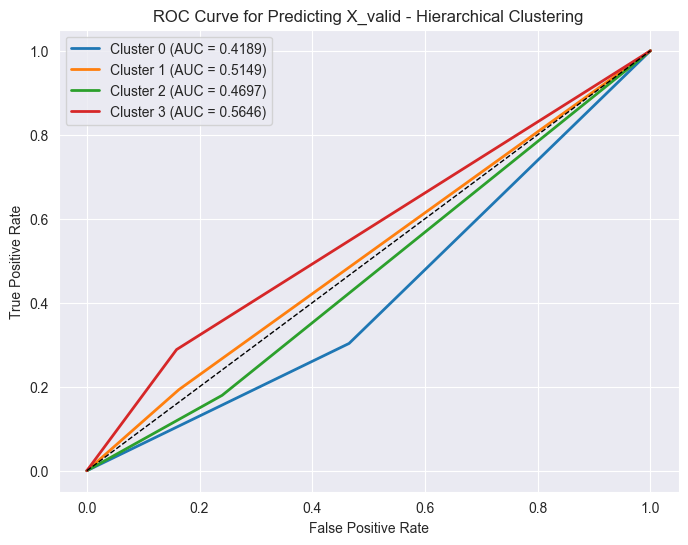

In [36]:
## (Option) Hierarchical Clustering

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ---------- Hierarchical Clustering ----------
hc = AgglomerativeClustering(
    n_clusters=len(label_encoder.classes_),  # クラス数に合わせる
    linkage='ward'                           # linkage方法 ('ward', 'complete', 'average' など)
)

# ---------- 学習 & 予測 ----------
y_pred_valid_hc = hc.fit_predict(X_valid_scaled)

# ---------- Confusion Matrix ----------
cm_valid_hc = confusion_matrix(y_valid_encoded, y_pred_valid_hc)
print("\n=== Confusion Matrix (Hierarchical Clustering - Valid Data) ===")
print(cm_valid_hc)

# ---------- Classification Report ----------
print("\n=== Classification Report (Hierarchical Clustering - Valid Data) ===")
print(classification_report(y_valid_encoded, y_pred_valid_hc, target_names=label_encoder.classes_))

# ---------- ROC-AUC (参考値  本来評価基準が違う) ----------
# クラスタ番号を one-hot 化
y_bin_valid_hc = label_binarize(y_valid_encoded, classes=range(len(label_encoder.classes_)))
y_score_valid_hc = label_binarize(y_pred_valid_hc, classes=range(len(label_encoder.classes_)))

plt.figure(figsize=(8, 6))
for i in range(len(label_encoder.classes_)):
    fpr_hc, tpr_hc, _ = roc_curve(y_bin_valid_hc[:, i], y_score_valid_hc[:, i])
    roc_auc_hc = auc(fpr_hc, tpr_hc)
    plt.plot(fpr_hc, tpr_hc, lw=2, label=f'Cluster {i} (AUC = {roc_auc_hc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Predicting X_valid - Hierarchical Clustering')
plt.legend()
plt.show()


## 2. Use the Test Set to perform evaluation

- validation 用変数 → test 用変数に変更
- X_valid_scaled → X_test_scaled
- y_valid → y_test
- y_pred_valid_xxx_best → y_pred_test_xxx_best
- 出力タイトルも "Test Metrics" に変更

In [37]:
# テストデータを追加で読み込み
test_label_df = pd.read_csv('dataset/test_classes.csv')
test_label_df['label'] = test_label_df.apply(convert_to_single_label, axis=1)

# 特徴量抽出　trainと同じ関数を利用するのでtrain/test の特徴量の形式が揃う
test_features, test_labels = load_and_extract_features('dataset/coffee-leaf-diseases/test/images', test_label_df)

# y_test を文字列ラベルとして定義
y_test = test_labels['label']

# Train 側で fit 済みの label_encoder を再利用して数値化
y_test_encoded = label_encoder.transform(y_test)

# スケーリング　train データで fit 済みの scaler を使って transform のみ。ここで新しく fit しないのがポイント
# もし fit してしまうと train/test のスケーリング基準がズレてしまい、評価が正しくなくなる
X_test_scaled = scaler.transform(test_features)

#### Evaluation using the best parameters

In [38]:
# ---------- Decision Tree ----------
y_pred_test_dt_best = best_model_dt.predict(X_test_scaled)

print("\n=== Decision Tree Test Metrics ===")
print("Accuracy (subset accuracy):", accuracy_score(y_test, y_pred_test_dt_best))
print("Precision (micro):", precision_score(y_test, y_pred_test_dt_best, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_test, y_pred_test_dt_best, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_test, y_pred_test_dt_best, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_test, y_pred_test_dt_best, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_test, y_pred_test_dt_best, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_test, y_pred_test_dt_best, average='macro', zero_division=0))

# ---------- KNN ----------
y_pred_test_knn_best = best_model_knn.predict(X_test_scaled)

print("\n=== KNN Test Metrics ===")
print("Accuracy (subset accuracy):", accuracy_score(y_test, y_pred_test_knn_best))
print("Precision (micro):", precision_score(y_test, y_pred_test_knn_best, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_test, y_pred_test_knn_best, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_test, y_pred_test_knn_best, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_test, y_pred_test_knn_best, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_test, y_pred_test_knn_best, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_test, y_pred_test_knn_best, average='macro', zero_division=0))

# ---------- Logistic Regression ----------
y_pred_test_lr_best = best_model_lr.predict(X_test_scaled)

print("\n=== Logistic Regression Test Metrics ===")
print("Accuracy (subset accuracy):", accuracy_score(y_test, y_pred_test_lr_best))
print("Precision (micro):", precision_score(y_test, y_pred_test_lr_best, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_test, y_pred_test_lr_best, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_test, y_pred_test_lr_best, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_test, y_pred_test_lr_best, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_test, y_pred_test_lr_best, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_test, y_pred_test_lr_best, average='macro', zero_division=0))

# ---------- Neural Network ----------
y_pred_test_nn_best = best_model_nn.predict(X_test_scaled)

print("\n=== Neural Network Test Metrics ===")
print("Accuracy (subset accuracy):", accuracy_score(y_test, y_pred_test_nn_best))
print("Precision (micro):", precision_score(y_test, y_pred_test_nn_best, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_test, y_pred_test_nn_best, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_test, y_pred_test_nn_best, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_test, y_pred_test_nn_best, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_test, y_pred_test_nn_best, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_test, y_pred_test_nn_best, average='macro', zero_division=0))


=== Decision Tree Test Metrics ===
Accuracy (subset accuracy): 0.6
Precision (micro): 0.6
Recall (micro): 0.6
F1-score (micro): 0.6
Precision (macro): 0.5777687626774848
Recall (macro): 0.6011314655172414
F1-score (macro): 0.586070764740924

=== KNN Test Metrics ===
Accuracy (subset accuracy): 0.65
Precision (micro): 0.65
Recall (micro): 0.65
F1-score (micro): 0.65
Precision (macro): 0.6245017281105991
Recall (macro): 0.6426185344827586
F1-score (macro): 0.6284756163788422

=== Logistic Regression Test Metrics ===
Accuracy (subset accuracy): 0.82
Precision (micro): 0.82
Recall (micro): 0.82
F1-score (micro): 0.82
Precision (macro): 0.8196225071225072
Recall (macro): 0.840642959770115
F1-score (macro): 0.8178506191488522

=== Neural Network Test Metrics ===
Accuracy (subset accuracy): 0.67
Precision (micro): 0.67
Recall (micro): 0.67
F1-score (micro): 0.67
Precision (macro): 0.666917389258587
Recall (macro): 0.6874102011494253
F1-score (macro): 0.6739556138060133


In [39]:
results_test = []
for name, model, y_pred in [
    ("Decision Tree", best_model_dt, y_pred_test_dt_best),
    ("KNN", best_model_knn, y_pred_test_knn_best),
    ("Logistic Regression", best_model_lr, y_pred_test_lr_best),
    ("Neural Network", best_model_nn, y_pred_test_nn_best)
]:
    results_test.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision (micro)": precision_score(y_test, y_pred, average='micro', zero_division=0),
        "Recall (micro)": recall_score(y_test, y_pred, average='micro', zero_division=0),
        "F1-score (micro)": f1_score(y_test, y_pred, average='micro', zero_division=0),
        "Precision (macro)": precision_score(y_test, y_pred, average='macro', zero_division=0),
        "Recall (macro)": recall_score(y_test, y_pred, average='macro', zero_division=0),
        "F1-score (macro)": f1_score(y_test, y_pred, average='macro', zero_division=0),
    })

pd.DataFrame(results_test)

,Model,Accuracy,Precision (micro),Recall (micro),F1-score (micro),Precision (macro),Recall (macro),F1-score (macro)
0,Decision Tree,0.60,0.60,0.60,0.60,0.577769,0.601131,0.586071
1,KNN,0.65,0.65,0.65,0.65,0.624502,0.642619,0.628476
2,Logistic Regression,0.82,0.82,0.82,0.82,0.819623,0.840643,0.817851
3,Neural Network,0.67,0.67,0.67,0.67,0.666917,0.687410,0.673956


### Confusion Matrix Heatmap

Confusion matrix
- y_valid → y_test に変更
- y_pred_valid_xxx_best → y_pred_test_xxx_best に変更（もし test 用に別変数を作っているなら）
- カラーマップやタイトルを変えると見やすくなる

#### One by One

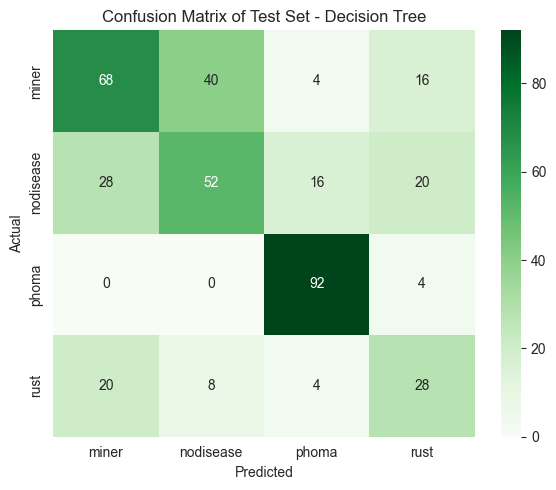

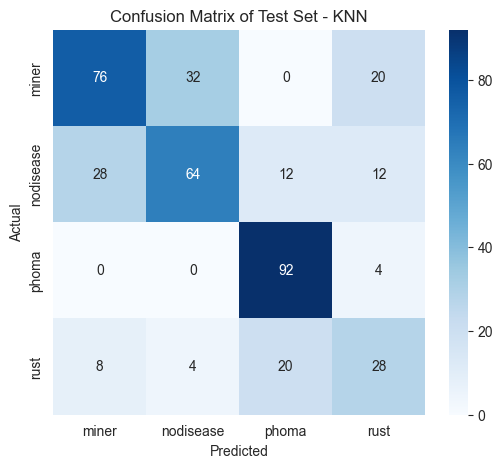

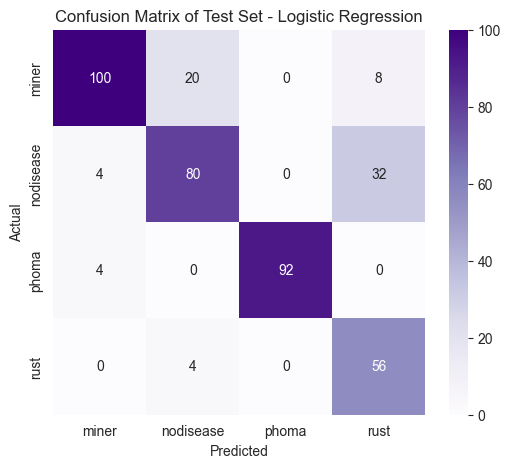

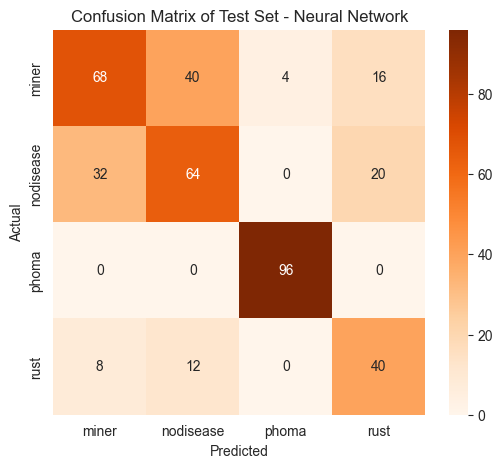

In [40]:
labels = sorted(list(set(y_test)))  # ラベル定義

# Decision Tree
cm_test_dt = confusion_matrix(y_test, y_pred_test_dt_best)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_test_dt,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Test Set - Decision Tree')
plt.tight_layout()
plt.show()

# KNN
cm_test_knn = confusion_matrix(y_test, y_pred_test_knn_best)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_test_knn,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Test Set - KNN')
plt.show()

# Logistic Regression
cm_test_lr = confusion_matrix(y_test, y_pred_test_lr_best)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_test_lr,
    annot=True,
    fmt='d',
    cmap='Purples',
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Test Set - Logistic Regression')
plt.show()

# Neural Network
cm_test_nn = confusion_matrix(y_test, y_pred_test_nn_best)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_test_nn,
    annot=True,
    fmt='d',
    cmap='Oranges',
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Test Set - Neural Network')
plt.show()

#### Subplot

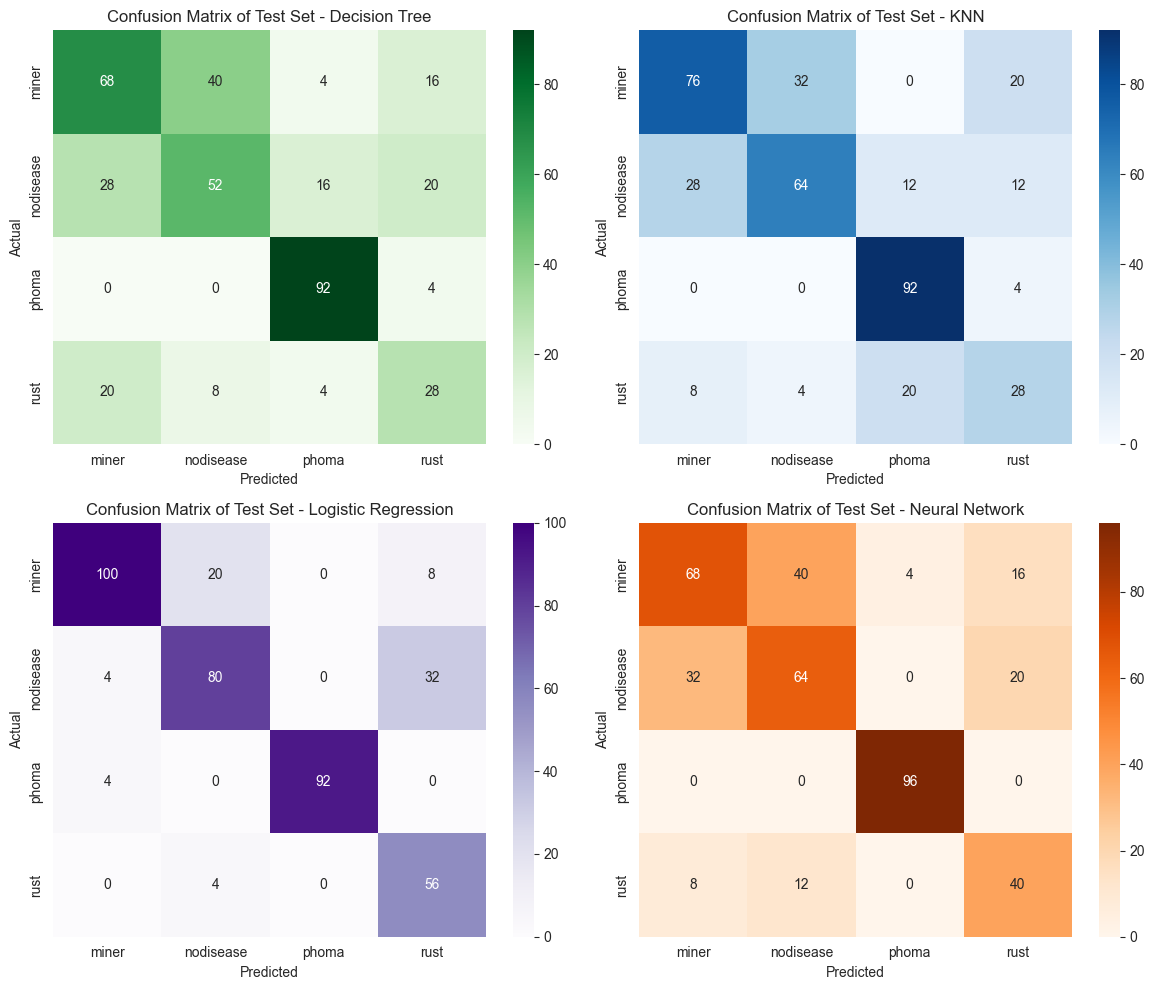

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ラベル定義
labels = sorted(list(set(y_test)))

# 各モデルの混同行列を計算
cm_test_dt = confusion_matrix(y_test, y_pred_test_dt_best, labels=labels)
cm_test_knn = confusion_matrix(y_test, y_pred_test_knn_best, labels=labels)
cm_test_lr = confusion_matrix(y_test, y_pred_test_lr_best, labels=labels)
cm_test_nn = confusion_matrix(y_test, y_pred_test_nn_best, labels=labels)

# サブプロット作成 (2行×2列)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 各モデルを順番に描画
for ax, cm, title, cmap in zip(
    axes.flatten(),
    [cm_test_dt, cm_test_knn, cm_test_lr, cm_test_nn],
    ["Decision Tree", "KNN", "Logistic Regression", "Neural Network"],
    ["Greens", "Blues", "Purples", "Oranges"]
):
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title(f"Confusion Matrix of Test Set - {title}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()

### ROC-AUC Curves

#### One by One

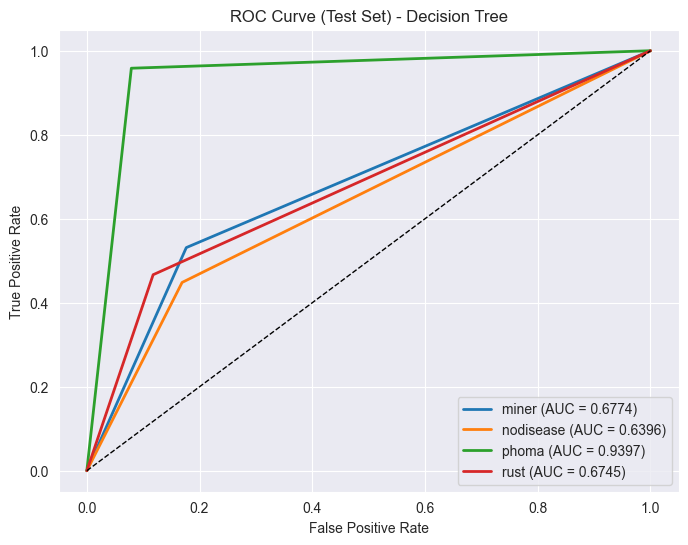

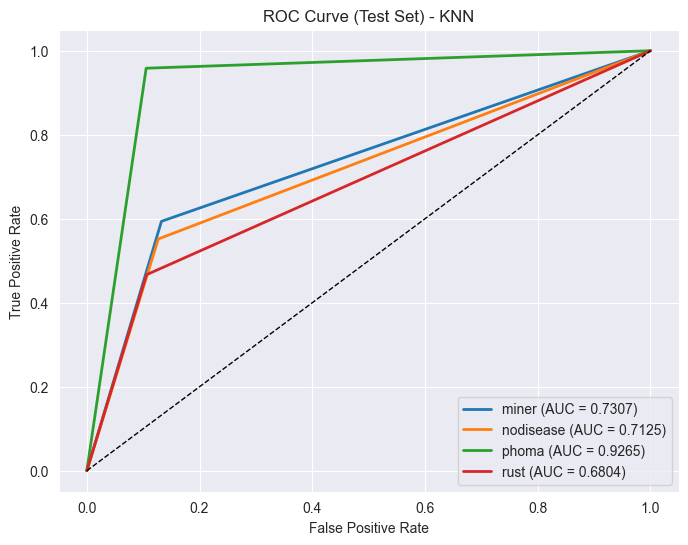

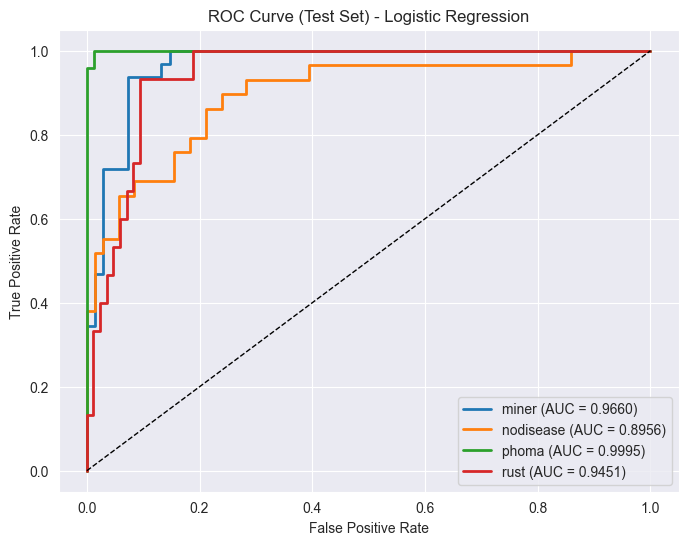

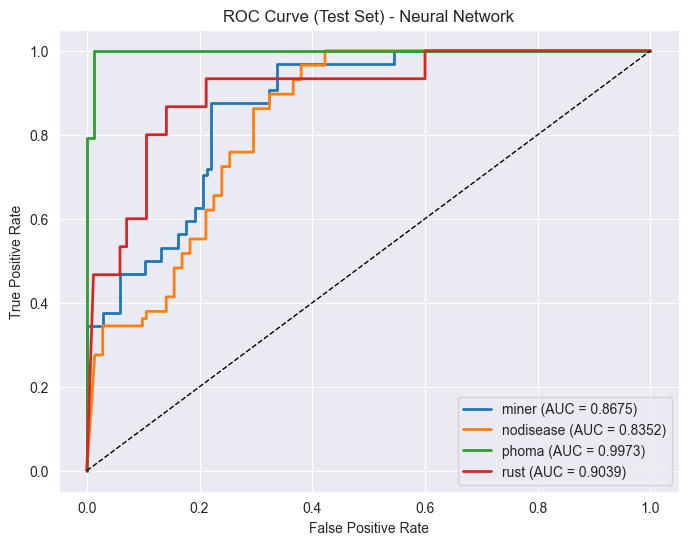

In [42]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# ---------- Decision Tree ----------
y_score_test_dt_best = best_model_dt.predict_proba(X_test_scaled)
y_bin_test_dt_best = label_binarize(y_test, classes=best_model_dt.classes_)
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(best_model_dt.classes_):
    fpr_dt, tpr_dt, _ = roc_curve(y_bin_test_dt_best[:, i], y_score_test_dt_best[:, i])
    roc_auc_dt_best = auc(fpr_dt, tpr_dt)
    plt.plot(fpr_dt, tpr_dt, lw=2, label=f'{class_name} (AUC = {roc_auc_dt_best:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Set) - Decision Tree')
plt.legend()
plt.show()

# ---------- KNN ----------
y_score_test_knn_best = best_model_knn.predict_proba(X_test_scaled)
y_bin_test_knn_best = label_binarize(y_test, classes=best_model_knn.classes_)
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(best_model_knn.classes_):
    fpr_knn, tpr_knn, _ = roc_curve(y_bin_test_knn_best[:, i], y_score_test_knn_best[:, i])
    roc_auc_knn_best = auc(fpr_knn, tpr_knn)
    plt.plot(fpr_knn, tpr_knn, lw=2, label=f'{class_name} (AUC = {roc_auc_knn_best:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Set) - KNN')
plt.legend()
plt.show()

# ---------- Logistic Regression ----------
y_score_test_lr_best = best_model_lr.predict_proba(X_test_scaled)
y_bin_test_lr_best = label_binarize(y_test, classes=best_model_lr.classes_)
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(best_model_lr.classes_):
    fpr_lr, tpr_lr, _ = roc_curve(y_bin_test_lr_best[:, i], y_score_test_lr_best[:, i])
    roc_auc_lr_best = auc(fpr_lr, tpr_lr)
    plt.plot(fpr_lr, tpr_lr, lw=2, label=f'{class_name} (AUC = {roc_auc_lr_best:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Set) - Logistic Regression')
plt.legend()
plt.show()

# ---------- Neural Network ----------
y_score_test_nn_best = best_model_nn.predict_proba(X_test_scaled)
y_bin_test_nn_best = label_binarize(y_test, classes=best_model_nn.classes_)
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(best_model_nn.classes_):
    fpr_nn, tpr_nn, _ = roc_curve(y_bin_test_nn_best[:, i], y_score_test_nn_best[:, i])
    roc_auc_nn_best = auc(fpr_nn, tpr_nn)
    plt.plot(fpr_nn, tpr_nn, lw=2, label=f'{class_name} (AUC = {roc_auc_nn_best:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Set) - Neural Network')
plt.legend()
plt.show()

#### Subplot


=== Decision Tree per-class AUC (Test Data) ===
miner: 0.6774
nodisease: 0.6396
phoma: 0.9397
rust: 0.6745
Decision Tree - Macro-average AUC: 0.7328, Micro-average AUC: 0.7333

=== KNN per-class AUC (Test Data) ===
miner: 0.7307
nodisease: 0.7125
phoma: 0.9265
rust: 0.6804
KNN - Macro-average AUC: 0.7625, Micro-average AUC: 0.7667

=== Logistic Regression per-class AUC (Test Data) ===
miner: 0.9660
nodisease: 0.8956
phoma: 0.9995
rust: 0.9451
Logistic Regression - Macro-average AUC: 0.9515, Micro-average AUC: 0.9539

=== Neural Network per-class AUC (Test Data) ===
miner: 0.8675
nodisease: 0.8352
phoma: 0.9973
rust: 0.9039
Neural Network - Macro-average AUC: 0.9010, Micro-average AUC: 0.9190


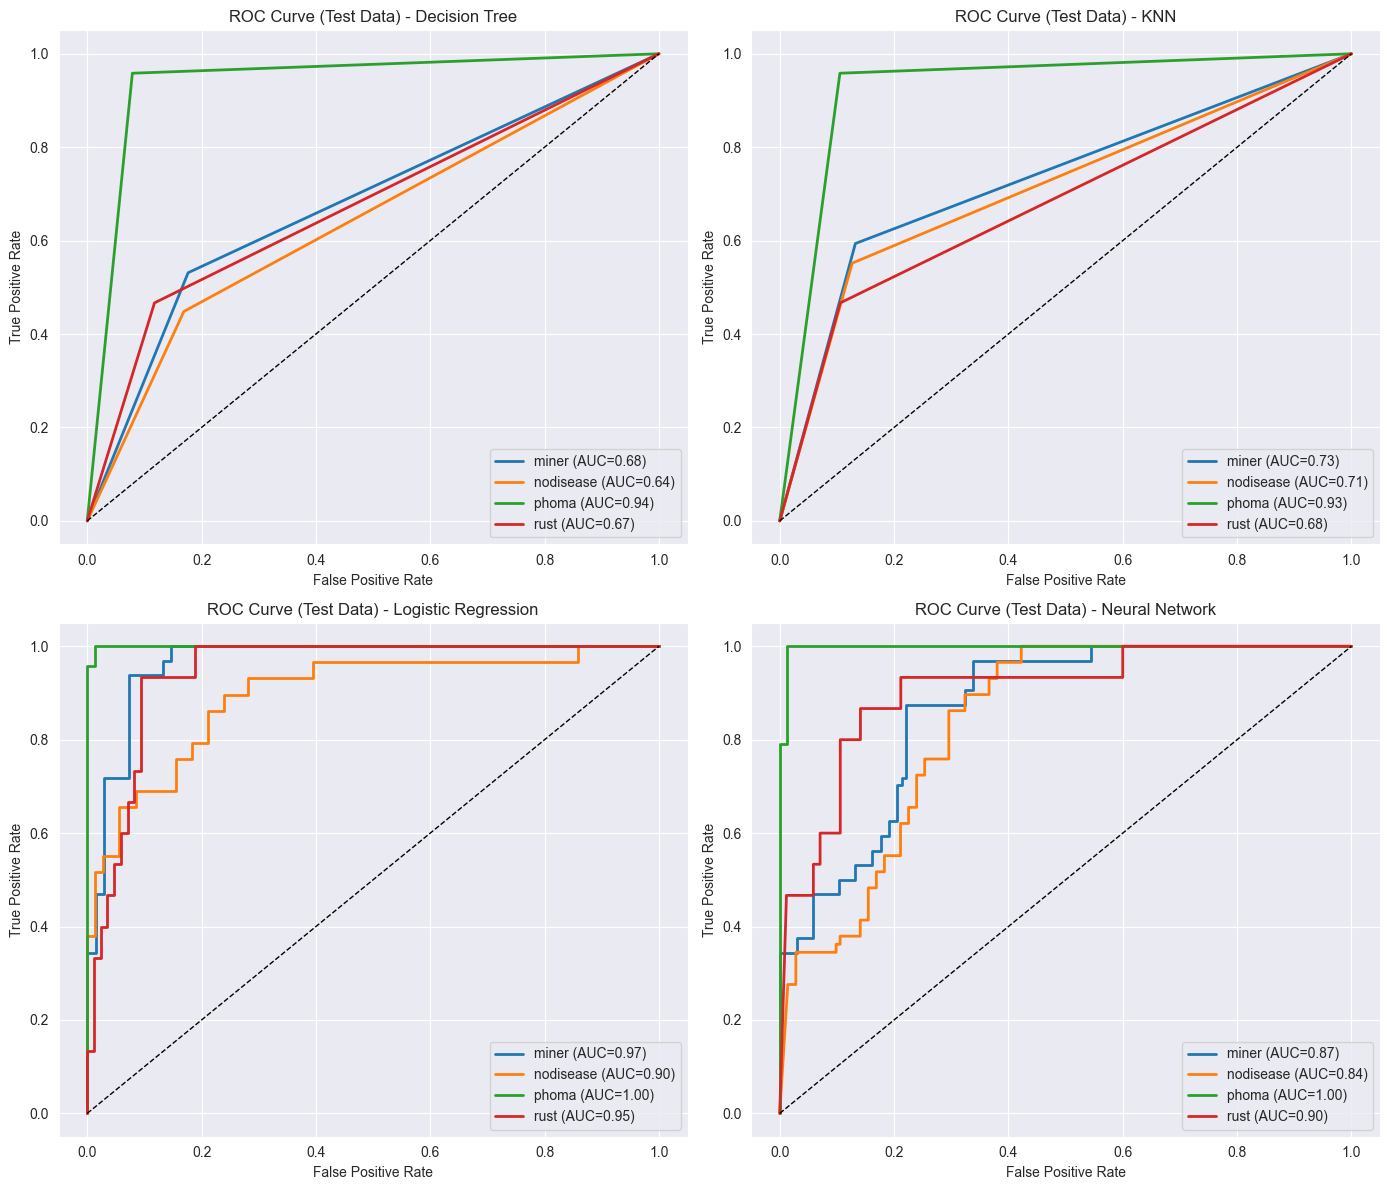

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

# 各モデルのスコアとバイナライズ済みラベル
models_info = [
    ("Decision Tree", best_model_dt, y_pred_test_dt_best),
    ("KNN", best_model_knn, y_pred_test_knn_best),
    ("Logistic Regression", best_model_lr, y_pred_test_lr_best),
    ("Neural Network", best_model_nn, y_pred_test_nn_best)
]

# サブプロット作成
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for ax, (name, model, y_pred) in zip(axes.flatten(), models_info):
    # 確率スコア
    y_score = model.predict_proba(X_test_scaled)
    # バイナライズラベル
    y_bin = label_binarize(y_test, classes=model.classes_)

    print(f"\n=== {name} per-class AUC (Test Data) ===")
    # 各クラスごとの ROC 曲線
    for i, class_name in enumerate(model.classes_):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC={roc_auc:.2f})')
        # ★ printでも出力
        print(f"{class_name}: {roc_auc:.4f}")

    # 基準線
    ax.plot([0, 1], [0, 1], 'k--', lw=1)
    ax.set_title(f"ROC Curve (Test Data) - {name}")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend()

    # Macro/Micro 平均 AUC を print
    macro_auc = roc_auc_score(y_bin, y_score, average="macro")
    micro_auc = roc_auc_score(y_bin, y_score, average="micro")
    print(f"{name} - Macro-average AUC: {macro_auc:.4f}, Micro-average AUC: {micro_auc:.4f}")

plt.tight_layout()
plt.show()

## 3. Combine the Train Set (Valid Set) and Test Set to retrain and perform evaluation


- train/test のラベル CSV を結合 → all_label_df
- 画像フォルダも両方読み込んで結合 → all_features, all_labels
- scaler.fit_transform は結合後の全データに対して実行
- train_test_split で 80:20 に再分割（stratify=y_all を入れるとクラス比率が保たれる）

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
import numpy as np

# --- Train/Test ラベルを読み込み ---
train_label_df = pd.read_csv('dataset/train_classes.csv')
test_label_df  = pd.read_csv('dataset/test_classes.csv')

# --- 複数ラベルを単一ラベルに変換 ---
train_label_df['label'] = train_label_df.apply(convert_to_single_label, axis=1)
test_label_df['label']  = test_label_df.apply(convert_to_single_label, axis=1)

print(train_label_df.head())   # ★ 確認用
print(test_label_df.head())    # ★ 確認用

# --- 特徴量抽出 ---
train_features, train_labels = load_and_extract_features(
    'dataset/coffee-leaf-diseases/train/images', train_label_df
)
test_features, test_labels = load_and_extract_features(
    'dataset/coffee-leaf-diseases/test/images', test_label_df
)

# --- Combine (Train+Test を結合) ---
all_features = np.vstack([train_features, test_features])   # 特徴量を縦方向に結合
all_labels   = pd.concat([train_labels['label'], test_labels['label']],
                         axis=0, ignore_index=True)         # ラベル列だけを結合 → Seriesになる

# --- ラベル分布を確認 ---
print(all_labels.value_counts())   # ←ここに入れると良い

# --- Combine データを学習用と検証用に分割 ---
X_train, X_valid, y_train, y_valid = train_test_split(
    all_features,
    all_labels,
    test_size=0.2,
    stratify=all_labels,     # クラスの割合を保ったまま分割（偏り防止）
    random_state=123
)

# --- ラベルの数値化 ---
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_valid_encoded = label_encoder.transform(y_valid)

print("Classes:", label_encoder.classes_)
print("y_train_encoded sample:", y_train_encoded[:10])
print("y_valid_encoded sample:", y_valid_encoded[:10])

# --- 特徴量の標準化 ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)   # 学習用データで fit
X_valid_scaled = scaler.transform(X_valid)       # 検証用データは transform のみ

   id  miner  rust  phoma      label
0   0      0     0      0  nodisease
1   1      0     0      0  nodisease
2   2      0     0      0  nodisease
3   3      0     0      0  nodisease
4   4      0     0      0  nodisease
   id  miner  rust  phoma  label
0  64      1     0      0  miner
1  65      1     0      0  miner
2  66      1     0      0  miner
3  67      1     0      0  miner
4  68      1     0      0  miner
label
phoma        484
miner        460
nodisease    400
rust         320
Name: count, dtype: int64
Classes: ['miner' 'nodisease' 'phoma' 'rust']
y_train_encoded sample: [2 3 1 0 2 2 2 1 2 0]
y_valid_encoded sample: [0 2 2 2 1 3 1 2 1 0]


これで「train/test を統合して 80:20 に分割したデータ」で、GridSearchCV を使った最適化と評価が一通りできる

### Hyperparameter Tuning and Grid Search

train+test を結合して再分割したデータに対して、各モデルを Grid Search で最適化 → 新しい hold-out test データで評価、という一連の「最終評価プロセス」が完成

In [45]:
# ---------- Decision Tree ----------
dt = DecisionTreeClassifier(max_features=None, random_state=123, splitter='best')

param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(1, 21)) + [None],
    'min_samples_split': range(2, 11),
    'min_samples_leaf': range(1, 6)
}

grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=10)
grid_search_dt.fit(X_train_scaled, y_train)   # CombineデータのX_train_scaled, y_trainを使用

best_model_dt = grid_search_dt.best_estimator_
print("Decision Tree best params:", grid_search_dt.best_params_)
print("Decision Tree CV score:", grid_search_dt.best_score_)


# ---------- KNN ----------
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, n_jobs=-1, p=2, weights='uniform')

param_grid_knn = {
    'metric': ['euclidean', 'manhattan'],
    'n_neighbors': range(1, 21),
}

grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=10)
grid_search_knn.fit(X_train_scaled, y_train)

best_model_knn = grid_search_knn.best_estimator_
print("KNN best params:", grid_search_knn.best_params_)
print("KNN CV score:", grid_search_knn.best_score_)


# ---------- Logistic Regression ----------
lr = LogisticRegression(max_iter=1000, random_state=123)

param_grid_lr = {
    'solver': ['lbfgs', 'saga'],
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2']
}

grid_search_lr = GridSearchCV(lr, param_grid_lr, cv=10, scoring='accuracy', n_jobs=-1)
grid_search_lr.fit(X_train_scaled, y_train)

best_model_lr = grid_search_lr.best_estimator_
print("Logistic Regression best params:", grid_search_lr.best_params_)
print("Logistic Regression CV score:", grid_search_lr.best_score_)


# ---------- Neural Network ----------
nn = MLPClassifier(max_iter=5000, random_state=123)

param_grid_nn = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'solver': ['adam', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01]
}

grid_search_nn = GridSearchCV(nn, param_grid_nn, cv=10, scoring='accuracy', n_jobs=-1)
grid_search_nn.fit(X_train_scaled, y_train)

best_model_nn = grid_search_nn.best_estimator_
print("Neural Network best params:", grid_search_nn.best_params_)
print("Neural Network CV score:", grid_search_nn.best_score_)

Decision Tree best params: {'criterion': 'entropy', 'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 2}
Decision Tree CV score: 0.9864829985411289
KNN best params: {'metric': 'manhattan', 'n_neighbors': 1}
KNN CV score: 0.9872461003254405
Logistic Regression best params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Logistic Regression CV score: 0.728750981932443
Neural Network best params: {'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001, 'solver': 'lbfgs'}
Neural Network CV score: 0.9954999438895747


In [46]:
pd.set_option('display.max_colwidth', None)  # 列の表示幅を制限しない
pd.set_option('display.max_columns', None)   # 全列を表示
pd.set_option('display.width', None)         # 横幅制限なし

results_combine = []
for name, gs in [("Decision Tree", grid_search_dt),
                 ("KNN", grid_search_knn),
                 ("Logistic Regression", grid_search_lr),
                 ("Neural Network", grid_search_nn)]:
    results_combine.append({
        "Model": name,
        "Best Params": gs.best_params_,
        "CV Score": gs.best_score_
    })

pd.DataFrame(results_combine)

,Model,Best Params,CV Score
0,Decision Tree,"{'criterion': 'entropy', 'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 2}",0.986483
1,KNN,"{'metric': 'manhattan', 'n_neighbors': 1}",0.987246
2,Logistic Regression,"{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}",0.728751
3,Neural Network,"{'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001, 'solver': 'lbfgs'}",0.995500


### Evaluation using the best parameters

In [47]:
# ---------- Decision Tree ----------
y_pred_valid_dt_best = best_model_dt.predict(X_valid_scaled)

print("\n=== Decision Tree Overall Metrics (Combine) ===")
print("Accuracy:", accuracy_score(y_valid, y_pred_valid_dt_best))
print("Precision (micro):", precision_score(y_valid, y_pred_valid_dt_best, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_valid, y_pred_valid_dt_best, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_valid, y_pred_valid_dt_best, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_valid, y_pred_valid_dt_best, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_valid, y_pred_valid_dt_best, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_valid, y_pred_valid_dt_best, average='macro', zero_division=0))

# ---------- KNN ----------
y_pred_valid_knn_best = best_model_knn.predict(X_valid_scaled)

print("\n=== KNN Overall Metrics (Combine) ===")
print("Accuracy:", accuracy_score(y_valid, y_pred_valid_knn_best))
print("Precision (micro):", precision_score(y_valid, y_pred_valid_knn_best, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_valid, y_pred_valid_knn_best, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_valid, y_pred_valid_knn_best, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_valid, y_pred_valid_knn_best, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_valid, y_pred_valid_knn_best, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_valid, y_pred_valid_knn_best, average='macro', zero_division=0))

# ---------- Logistic Regression ----------
y_pred_valid_lr_best = best_model_lr.predict(X_valid_scaled)

print("\n=== Logistic Regression Overall Metrics (Combine) ===")
print("Accuracy:", accuracy_score(y_valid, y_pred_valid_lr_best))
print("Precision (micro):", precision_score(y_valid, y_pred_valid_lr_best, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_valid, y_pred_valid_lr_best, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_valid, y_pred_valid_lr_best, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_valid, y_pred_valid_lr_best, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_valid, y_pred_valid_lr_best, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_valid, y_pred_valid_lr_best, average='macro', zero_division=0))

# ---------- Neural Network ----------
y_pred_valid_nn_best = best_model_nn.predict(X_valid_scaled)

print("\n=== Neural Network Overall Metrics (Combine) ===")
print("Accuracy:", accuracy_score(y_valid, y_pred_valid_nn_best))
print("Precision (micro):", precision_score(y_valid, y_pred_valid_nn_best, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_valid, y_pred_valid_nn_best, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_valid, y_pred_valid_nn_best, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_valid, y_pred_valid_nn_best, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_valid, y_pred_valid_nn_best, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_valid, y_pred_valid_nn_best, average='macro', zero_division=0))


=== Decision Tree Overall Metrics (Combine) ===
Accuracy: 1.0
Precision (micro): 1.0
Recall (micro): 1.0
F1-score (micro): 1.0
Precision (macro): 1.0
Recall (macro): 1.0
F1-score (macro): 1.0

=== KNN Overall Metrics (Combine) ===
Accuracy: 1.0
Precision (micro): 1.0
Recall (micro): 1.0
F1-score (micro): 1.0
Precision (macro): 1.0
Recall (macro): 1.0
F1-score (macro): 1.0

=== Logistic Regression Overall Metrics (Combine) ===
Accuracy: 0.7177177177177178
Precision (micro): 0.7177177177177178
Recall (micro): 0.7177177177177178
F1-score (micro): 0.7177177177177178
Precision (macro): 0.7032054088233863
Recall (macro): 0.6980340934558494
F1-score (macro): 0.6978101386161256

=== Neural Network Overall Metrics (Combine) ===
Accuracy: 1.0
Precision (micro): 1.0
Recall (micro): 1.0
F1-score (micro): 1.0
Precision (macro): 1.0
Recall (macro): 1.0
F1-score (macro): 1.0


In [48]:
results_valid_combine = []
for name, y_pred in [
    ("Decision Tree", y_pred_valid_dt_best),
    ("KNN", y_pred_valid_knn_best),
    ("Logistic Regression", y_pred_valid_lr_best),
    ("Neural Network", y_pred_valid_nn_best)
]:
    results_valid_combine.append({
        "Model": name,
        "Accuracy": accuracy_score(y_valid, y_pred),
        "Precision (micro)": precision_score(y_valid, y_pred, average='micro', zero_division=0),
        "Recall (micro)": recall_score(y_valid, y_pred, average='micro', zero_division=0),
        "F1-score (micro)": f1_score(y_valid, y_pred, average='micro', zero_division=0),
        "Precision (macro)": precision_score(y_valid, y_pred, average='macro', zero_division=0),
        "Recall (macro)": recall_score(y_valid, y_pred, average='macro', zero_division=0),
        "F1-score (macro)": f1_score(y_valid, y_pred, average='macro', zero_division=0),
    })
pd.DataFrame(results_valid_combine)

,Model,Accuracy,Precision (micro),Recall (micro),F1-score (micro),Precision (macro),Recall (macro),F1-score (macro)
0,Decision Tree,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000
1,KNN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000
2,Logistic Regression,0.717718,0.717718,0.717718,0.717718,0.703205,0.698034,0.69781
3,Neural Network,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


### Confusion Matrix Heatmap

#### One by One

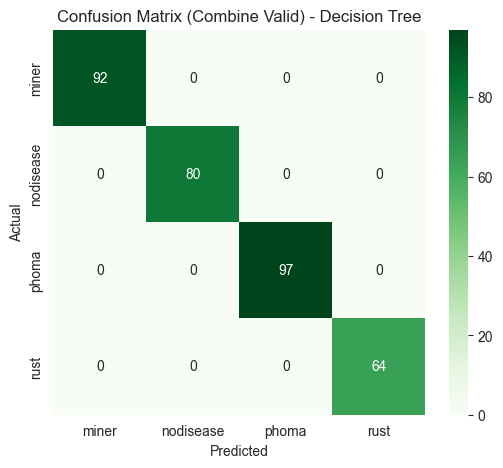

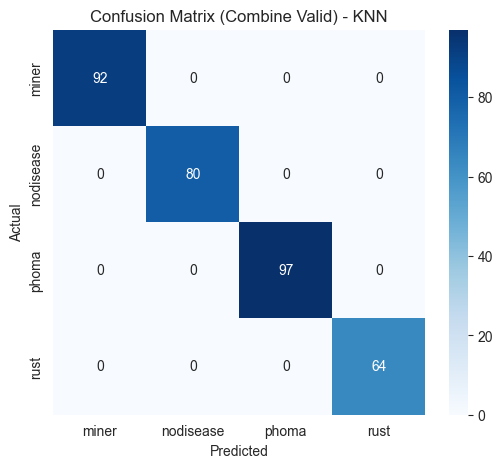

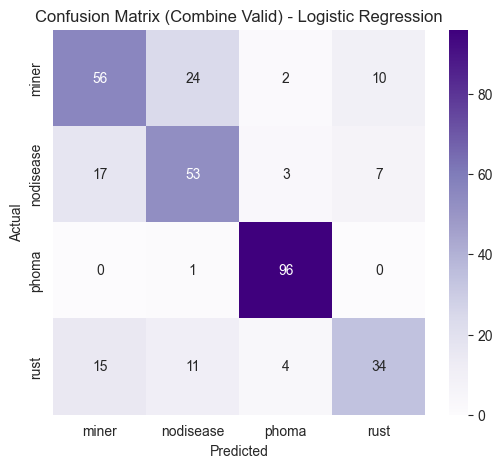

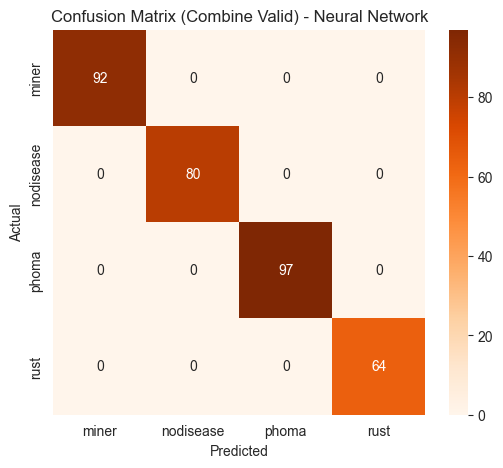

In [49]:
# Combineデータの検証ラベルを取得
labels = sorted(y_valid.unique())

# ---------- Decision Tree ----------
cm_valid_dt_best = confusion_matrix(y_valid, y_pred_valid_dt_best)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_valid_dt_best, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Combine Valid) - Decision Tree')
plt.show()

# ---------- KNN ----------
cm_valid_knn_best = confusion_matrix(y_valid, y_pred_valid_knn_best)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_valid_knn_best, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Combine Valid) - KNN')
plt.show()

# ---------- Logistic Regression ----------
cm_valid_lr_best = confusion_matrix(y_valid, y_pred_valid_lr_best)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_valid_lr_best, annot=True, fmt='d', cmap='Purples',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Combine Valid) - Logistic Regression')
plt.show()

# ---------- Neural Network ----------
cm_valid_nn_best = confusion_matrix(y_valid, y_pred_valid_nn_best)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_valid_nn_best, annot=True, fmt='d', cmap='Oranges',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Combine Valid) - Neural Network')
plt.show()

#### Side by Side

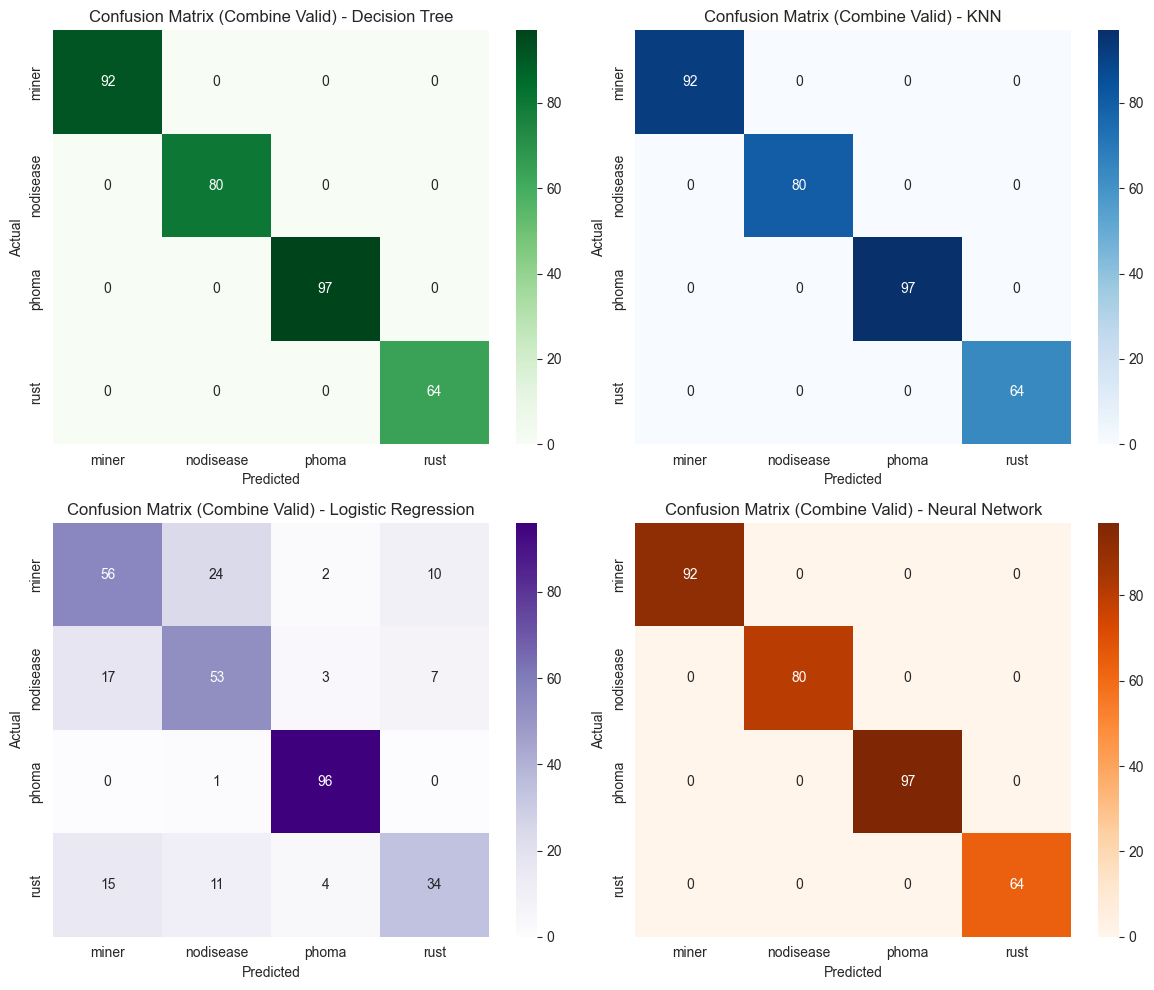

In [50]:
# Combineデータの検証ラベルを取得
labels = sorted(y_valid.unique())

# 各モデルの混同行列を計算
cm_valid_dt_best  = confusion_matrix(y_valid, y_pred_valid_dt_best, labels=labels)
cm_valid_knn_best = confusion_matrix(y_valid, y_pred_valid_knn_best, labels=labels)
cm_valid_lr_best  = confusion_matrix(y_valid, y_pred_valid_lr_best, labels=labels)
cm_valid_nn_best  = confusion_matrix(y_valid, y_pred_valid_nn_best, labels=labels)

# サブプロット作成 (2行×2列)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 各モデルを順番に描画
for ax, cm, title, cmap in zip(
    axes.flatten(),
    [cm_valid_dt_best, cm_valid_knn_best, cm_valid_lr_best, cm_valid_nn_best],
    ["Decision Tree", "KNN", "Logistic Regression", "Neural Network"],
    ["Greens", "Blues", "Purples", "Oranges"]
):
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title(f"Confusion Matrix (Combine Valid) - {title}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()

### ROC-AUC Curves

#### One by One

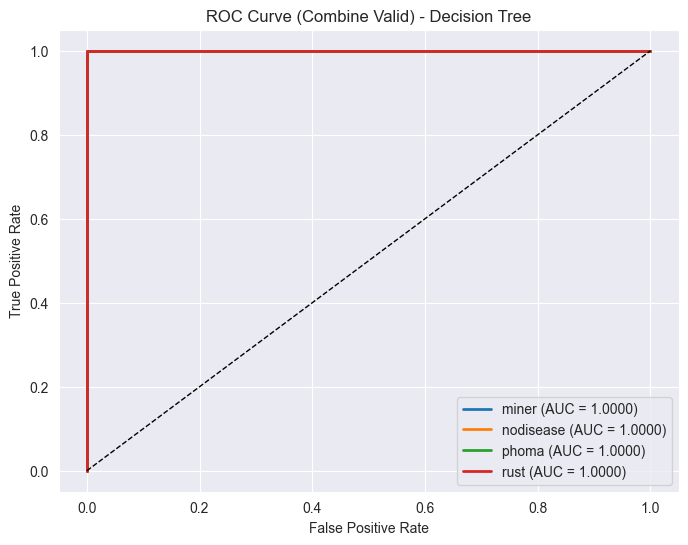

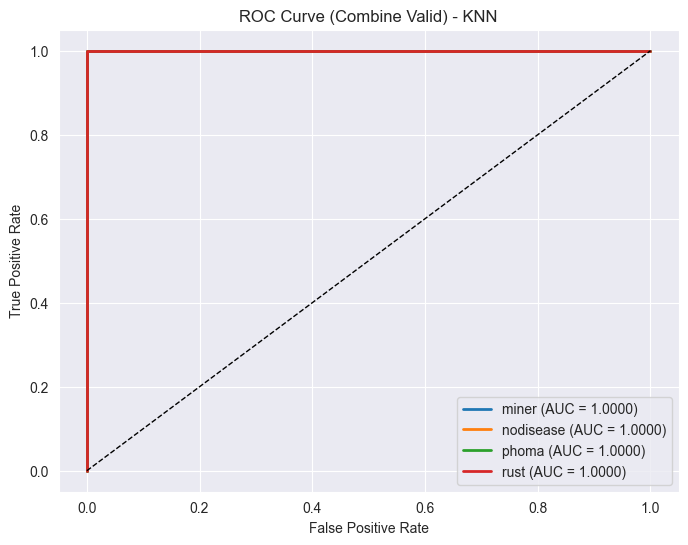

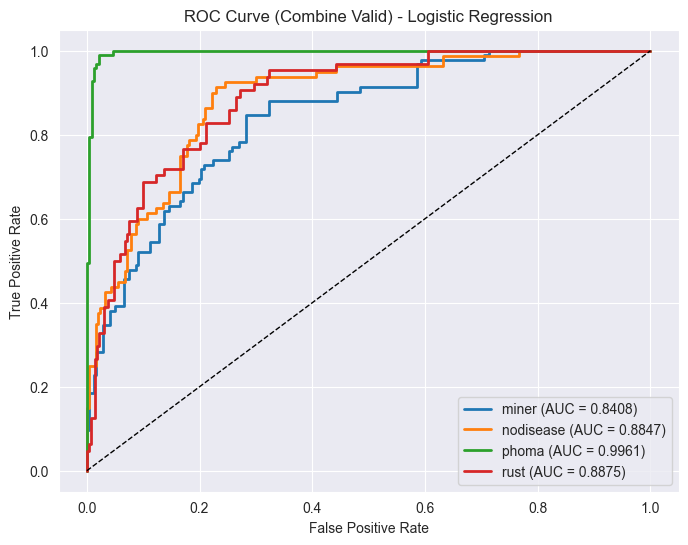

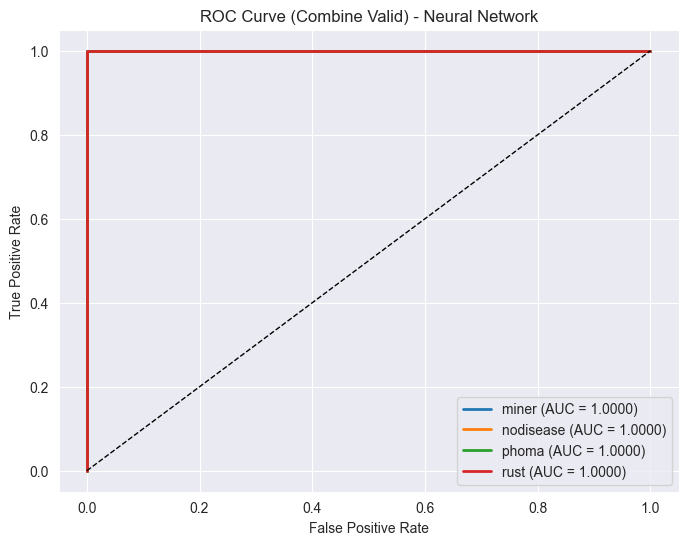

In [51]:
# Combineデータの検証ラベルをバイナリ化するためにクラスを取得
labels = sorted(y_valid.unique())

# ---------- Decision Tree ----------
y_score_valid_dt_best = best_model_dt.predict_proba(X_valid_scaled)
y_bin_valid_dt_best = label_binarize(y_valid, classes=best_model_dt.classes_)
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(best_model_dt.classes_):
    fpr_dt, tpr_dt, _ = roc_curve(y_bin_valid_dt_best[:, i], y_score_valid_dt_best[:, i])
    roc_auc_dt_best = auc(fpr_dt, tpr_dt)
    plt.plot(fpr_dt, tpr_dt, lw=2, label=f'{class_name} (AUC = {roc_auc_dt_best:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Combine Valid) - Decision Tree')
plt.legend()
plt.show()

# ---------- KNN ----------
y_score_valid_knn_best = best_model_knn.predict_proba(X_valid_scaled)
y_bin_valid_knn_best = label_binarize(y_valid, classes=best_model_knn.classes_)
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(best_model_knn.classes_):
    fpr_knn, tpr_knn, _ = roc_curve(y_bin_valid_knn_best[:, i], y_score_valid_knn_best[:, i])
    roc_auc_knn_best = auc(fpr_knn, tpr_knn)
    plt.plot(fpr_knn, tpr_knn, lw=2, label=f'{class_name} (AUC = {roc_auc_knn_best:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Combine Valid) - KNN')
plt.legend()
plt.show()

# ---------- Logistic Regression ----------
y_score_valid_lr_best = best_model_lr.predict_proba(X_valid_scaled)
y_bin_valid_lr_best = label_binarize(y_valid, classes=best_model_lr.classes_)
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(best_model_lr.classes_):
    fpr_lr, tpr_lr, _ = roc_curve(y_bin_valid_lr_best[:, i], y_score_valid_lr_best[:, i])
    roc_auc_lr_best = auc(fpr_lr, tpr_lr)
    plt.plot(fpr_lr, tpr_lr, lw=2, label=f'{class_name} (AUC = {roc_auc_lr_best:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Combine Valid) - Logistic Regression')
plt.legend()
plt.show()

# ---------- Neural Network ----------
y_score_valid_nn_best = best_model_nn.predict_proba(X_valid_scaled)
y_bin_valid_nn_best = label_binarize(y_valid, classes=best_model_nn.classes_)
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(best_model_nn.classes_):
    fpr_nn, tpr_nn, _ = roc_curve(y_bin_valid_nn_best[:, i], y_score_valid_nn_best[:, i])
    roc_auc_nn_best = auc(fpr_nn, tpr_nn)
    plt.plot(fpr_nn, tpr_nn, lw=2, label=f'{class_name} (AUC = {roc_auc_nn_best:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Combine Valid) - Neural Network')
plt.legend()
plt.show()

#### Side by Side


=== Decision Tree per-class AUC (Combine Valid) ===
miner: 1.0000
nodisease: 1.0000
phoma: 1.0000
rust: 1.0000
Decision Tree - Macro-average AUC: 1.0000, Micro-average AUC: 1.0000

=== KNN per-class AUC (Combine Valid) ===
miner: 1.0000
nodisease: 1.0000
phoma: 1.0000
rust: 1.0000
KNN - Macro-average AUC: 1.0000, Micro-average AUC: 1.0000

=== Logistic Regression per-class AUC (Combine Valid) ===
miner: 0.8408
nodisease: 0.8847
phoma: 0.9961
rust: 0.8875
Logistic Regression - Macro-average AUC: 0.9023, Micro-average AUC: 0.9228

=== Neural Network per-class AUC (Combine Valid) ===
miner: 1.0000
nodisease: 1.0000
phoma: 1.0000
rust: 1.0000
Neural Network - Macro-average AUC: 1.0000, Micro-average AUC: 1.0000


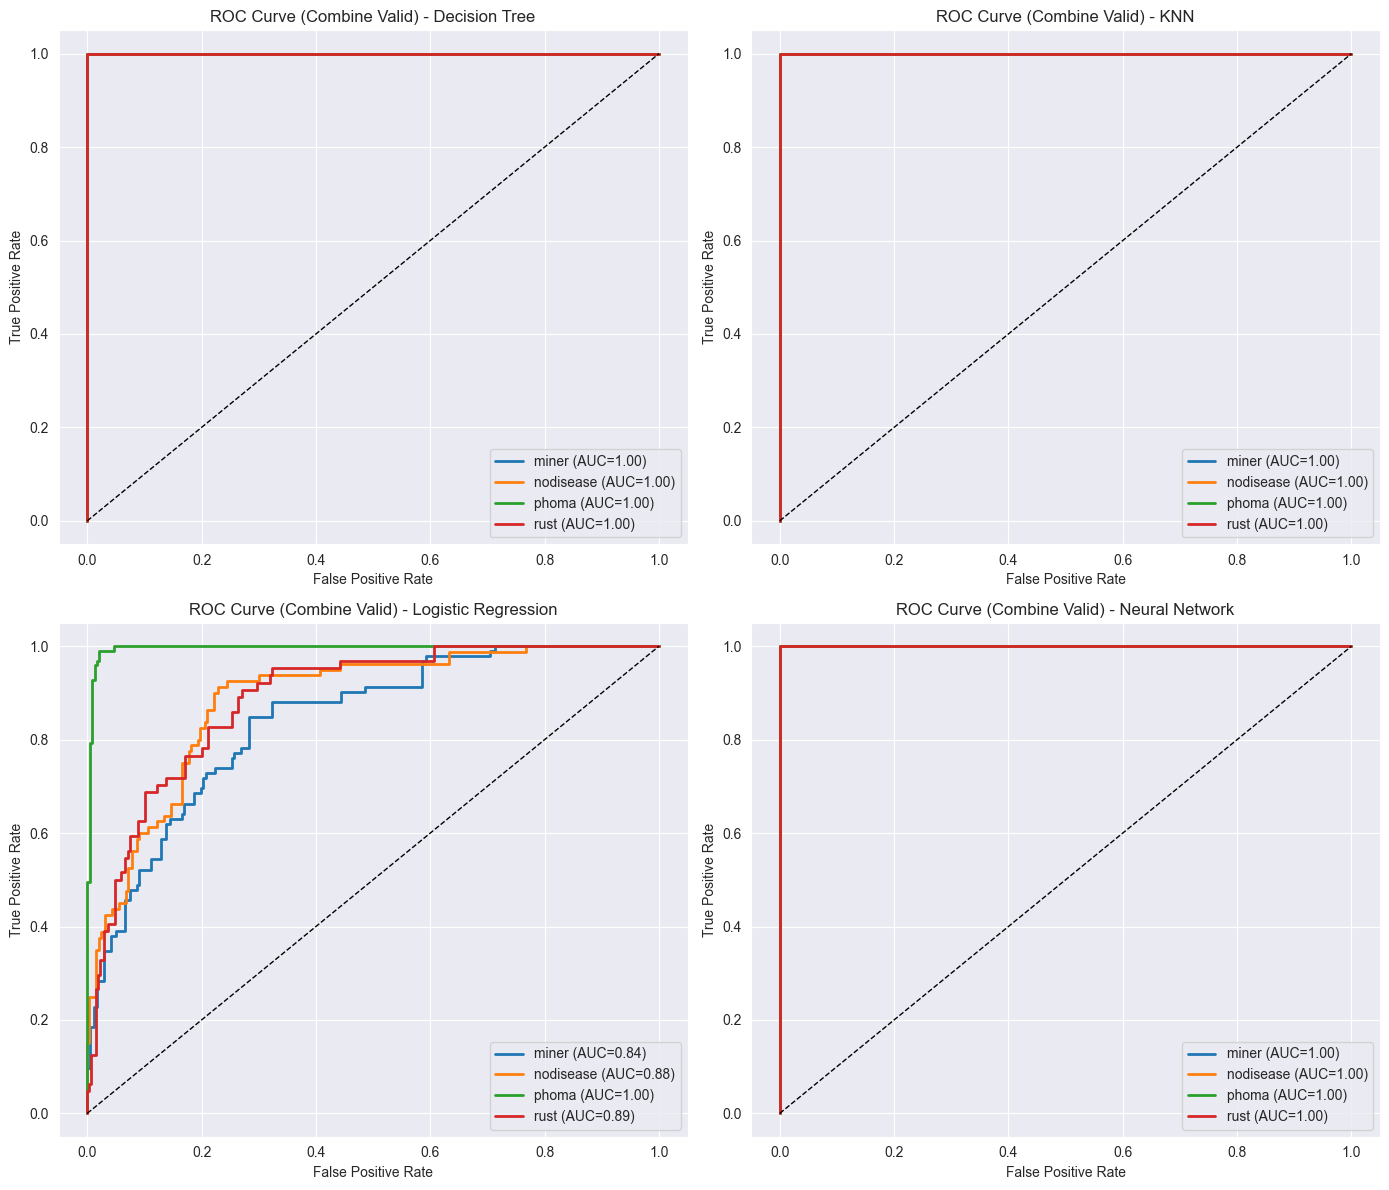

In [52]:
# 各モデルのスコアとバイナライズ済みラベル
models_info = [
    ("Decision Tree", best_model_dt, y_pred_valid_dt_best),
    ("KNN", best_model_knn, y_pred_valid_knn_best),
    ("Logistic Regression", best_model_lr, y_pred_valid_lr_best),
    ("Neural Network", best_model_nn, y_pred_valid_nn_best)
]

# サブプロット作成 (2行×2列)
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for ax, (name, model, y_pred) in zip(axes.flatten(), models_info):
    # Combineデータの検証セットに対する確率スコア
    y_score = model.predict_proba(X_valid_scaled)
    # バイナライズラベル
    y_bin = label_binarize(y_valid, classes=model.classes_)

    print(f"\n=== {name} per-class AUC (Combine Valid) ===")
    # 各クラスごとの ROC 曲線
    for i, class_name in enumerate(model.classes_):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC={roc_auc:.2f})')
        # ★ printでも出力
        print(f"{class_name}: {roc_auc:.4f}")

    # 基準線
    ax.plot([0, 1], [0, 1], 'k--', lw=1)
    ax.set_title(f"ROC Curve (Combine Valid) - {name}")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend()

    # Macro/Micro 平均 AUC を print
    macro_auc = roc_auc_score(y_bin, y_score, average="macro")
    micro_auc = roc_auc_score(y_bin, y_score, average="micro")
    print(f"{name} - Macro-average AUC: {macro_auc:.4f}, Micro-average AUC: {micro_auc:.4f}")

plt.tight_layout()
plt.show()